Ablation test

2025-08-10 21:28:50.652924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 21:28:50.653883: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 21:28:50.656748: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 21:28:50.664825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754832530.678220   28443 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754832530.68

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PG_CFC_without_dynamic_weights.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PG_CFC_with_fully_connected_weights.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LTC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PG_LTC_without_dynamic_weights.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PG_LTC_with_fully_connected_weights.keras


/home/ustc15/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


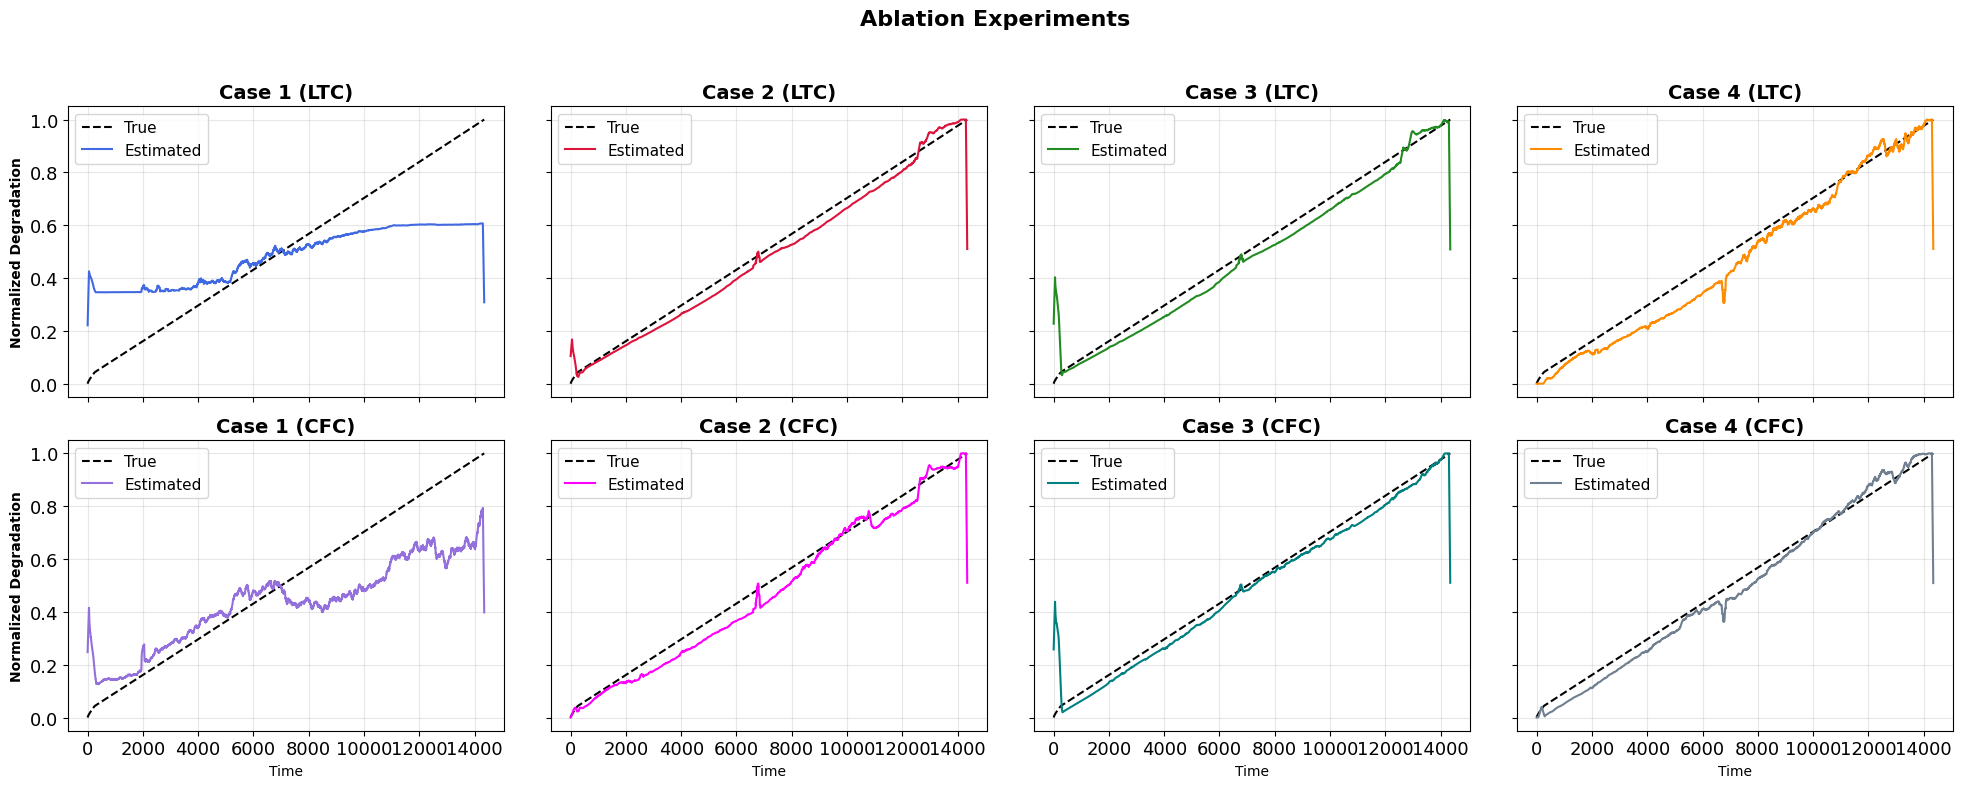

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.preprocess import process_features, moving_average
from models.PGNN import PGNN
from networks.networks import cfc_network, cfc_fc_network,ltc_network,ltc_fc_network

import tensorflow as tf
from utils.metrics import score_function

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- Setup directories ---
root_dir = os.getcwd()
feature_dir = os.path.join(root_dir, 'tf_features')
weights_dir = os.path.join(root_dir, 'model_weights')
stat_dir = os.path.join(root_dir, 'statistics')
results = []


pg_cfc_proposed = PGNN(cfc_network)
pg_cfc_proposed.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))

pg_cfc_without_pg = cfc_network()
pg_cfc_without_pg.compile(optimizer='adam', loss='mse')
pg_cfc_without_pg.load_weights(os.path.join(weights_dir, 'PG_CFC_without_PG_weights.keras'))

pg_cfc_without_dw = PGNN(cfc_network)
pg_cfc_without_dw.load_weights(os.path.join(weights_dir, 'PG_CFC_without_dynamic_weights.keras'))

pg_cfc_with_fc = PGNN(cfc_fc_network)
pg_cfc_with_fc.load_weights(os.path.join(weights_dir, 'PG_CFC_with_fully_connected_weights.keras'))

pg_ltc_proposed = PGNN(ltc_network)
pg_ltc_proposed.load_weights(os.path.join(weights_dir, 'PI_LTC.keras'))

pg_ltc_without_pg = ltc_network()
pg_ltc_without_pg.compile(optimizer='adam', loss='mse')
pg_ltc_without_pg.load_weights(os.path.join(weights_dir, 'PG_LTC_without_PG_weights.keras'))

pg_ltc_without_dw = PGNN(ltc_network)
pg_ltc_without_dw.load_weights(os.path.join(weights_dir, 'PG_LTC_without_dynamic_weights.keras'))

pg_ltc_with_fc = PGNN(ltc_fc_network)
pg_ltc_with_fc.load_weights(os.path.join(weights_dir, 'PG_LTC_with_fully_connected_weights.keras'))



#define MC models


# --- Define model dictionaries ---
cfc_models_dict = {
    "Case 1 (CFC)": pg_cfc_without_pg,
    "Case 2 (CFC)": pg_cfc_without_dw,
    "Case 3 (CFC)": pg_cfc_with_fc,
    "Case 4 (CFC)": pg_cfc_proposed
}

ltc_models_dict = {
    "Case 1 (LTC)": pg_ltc_without_pg,
    "Case 2 (LTC)": pg_ltc_without_dw,
    "Case 3 (LTC)": pg_ltc_with_fc,
    "Case 4 (LTC)": pg_ltc_proposed
}

# Merge all models into a single dictionary
all_models_dict = {**ltc_models_dict, **cfc_models_dict}

# --- Load Bearing1_1 data ---
bearing_name = "Bearing1_1"
try:
    df = pd.read_csv(os.path.join(feature_dir, f"{bearing_name}_features.csv"))

    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)
    t_data = df['Time'].values.reshape(-1, 1)
    T_data = (df['Temperature'].values + 273.15).reshape(-1, 1)
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)
    X = StandardScaler().fit_transform(X)
    y_true = df['Degradation'].values

except Exception as e:
    print(f"Failed to load bearing data: {e}")
    raise

# --- Plot Setup ---
plt.style.use('seaborn-v0_8-deep')
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)

# Define subtle but distinct colors
color_aleatoric = 'royalblue'
color_epistemic = 'darkorange'
color_total = 'forestgreen'
colors = ['royalblue', 'crimson', 'forestgreen', 'darkorange', 'mediumpurple', 'magenta', 'teal', 'slategray']

for i, (model_name, model) in enumerate(all_models_dict.items()):
    row = 0 if i < 4 else 1
    col = i % 4
    ax = axes[row, col]

    try:
        degradation = model.predict(X).flatten()
        degradation = np.clip(degradation, 0, 1)  # Ensure non-negative degradation
        x_vals = np.arange(len(degradation))

        ax.plot(y_true, label='True', color='black', linestyle='--')
        ax.plot(x_vals, moving_average(degradation), label='Estimated', color=colors[i])

        ax.set_title(model_name, fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
        if col == 0:
            ax.set_ylabel("Normalized Degradation", fontweight='bold')
        if row == 1:
            ax.set_xlabel("Time")

        # De-duplicate legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=11, loc='upper left')

        results.append({
            'Bearing': bearing_name,
            'Model': model_name,
            'MSE': mean_squared_error(y_true, degradation),
            'MAE': mean_absolute_error(y_true, degradation),
            'Score': score_function(y_true, degradation).numpy(),
            })

    except Exception as e:
        print(f"Error in model {model_name}: {e}")

# Final formatting
plt.suptitle("Ablation Experiments", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# update the csv
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(stat_dir, 'Paper04_PGLNS_ablation_results.csv'), index=False)


Performance Test on in-domain sample

2025-08-10 19:28:42.821173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 19:28:42.822126: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 19:28:42.824950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 19:28:42.832721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754825322.845725   12653 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754825322.84

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LTC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_TCN.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LSTM.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_GRU.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CNN.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_MLP.keras


449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


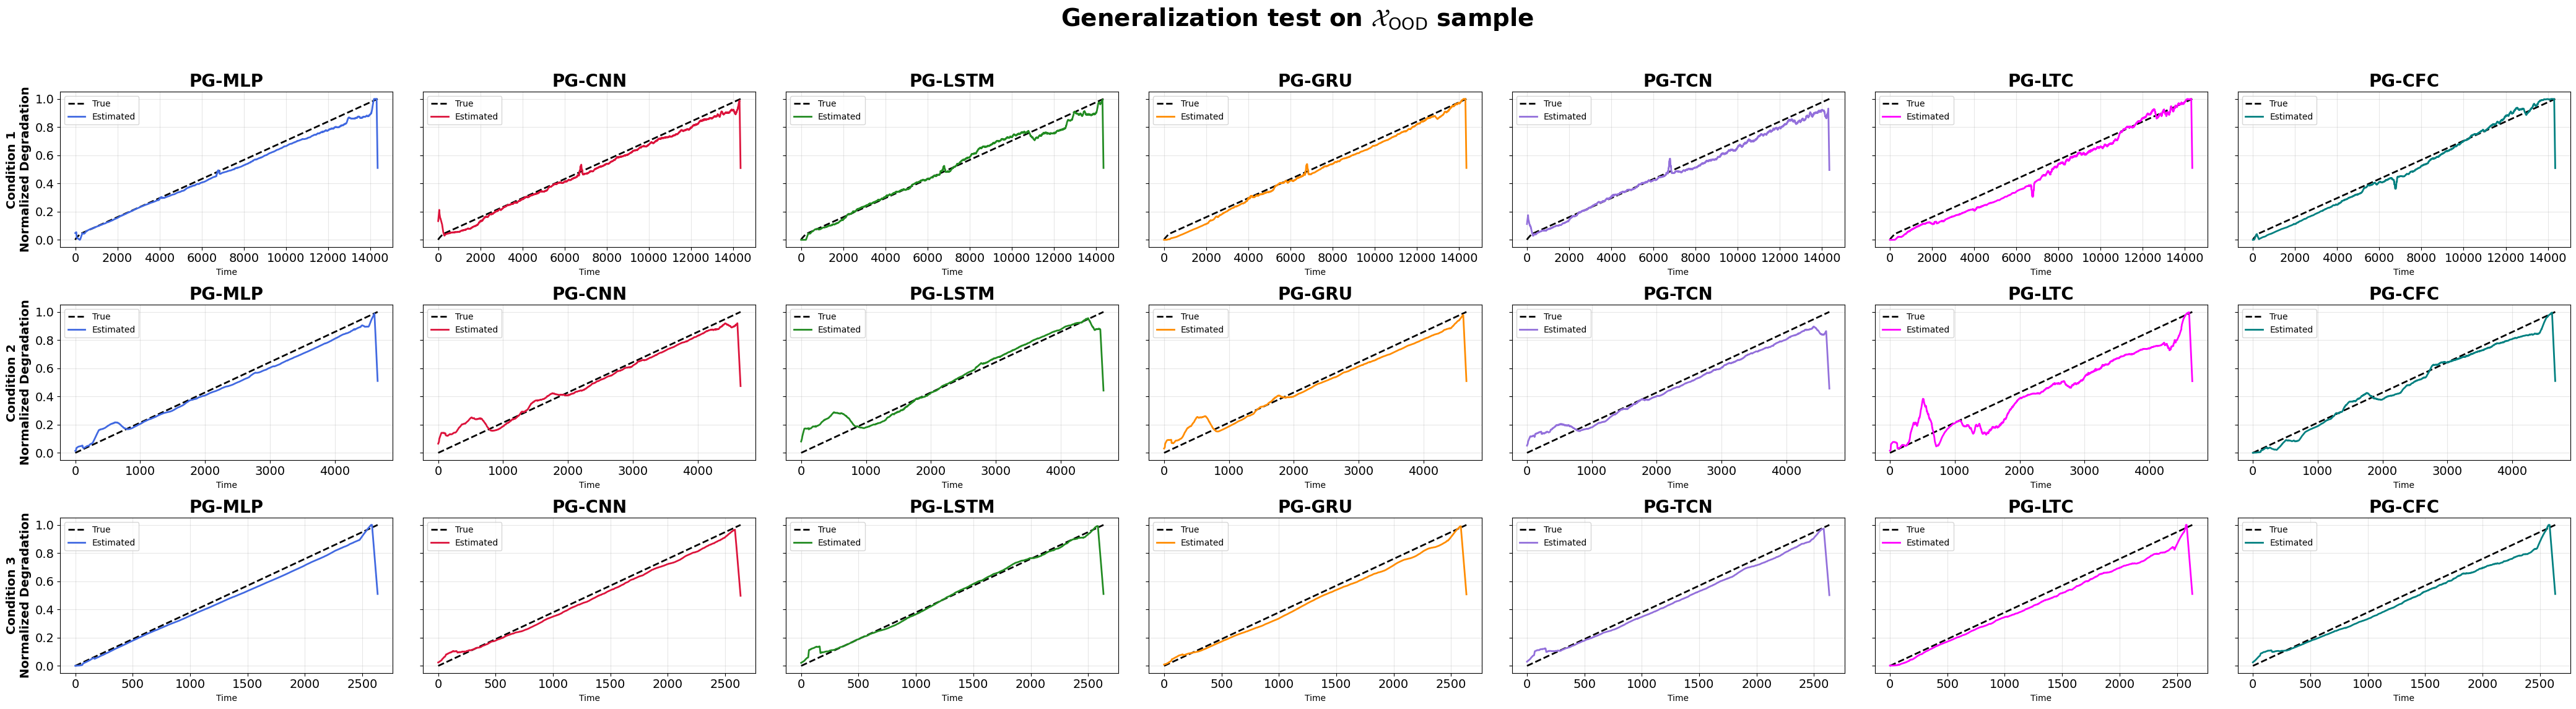

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from models.PGNN import PGNN
from networks.networks import cfc_network,ltc_network,tcn_network,lstm_network,gru_network,cnn_network,mlp_network
from utils.preprocess import process_features,moving_average  # This should handle 1D time series features
from utils.metrics import score_function


plt.style.use('seaborn-v0_8-deep')

# --- GLOBAL MATPLOTLIB STYLE SETTINGS ---
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Selected bearings and metadata
selected_bearings = [
    {'condition': 'Condition 1', 'bearing': 'Bearing1_1', 'failure': 'Outer'},
    {'condition': 'Condition 2', 'bearing': 'Bearing2_1', 'failure': 'Inner'},
    {'condition': 'Condition 3', 'bearing': 'Bearing3_1', 'failure': 'No Failure'}
]

# Directories
root_dir = os.getcwd()
feature_dir = os.path.join(root_dir, 'tf_features')
weights_dir = os.path.join(root_dir, 'model_weights')
stat_dir = os.path.join(root_dir, 'statistics')
plots_dir = os.path.join(root_dir, 'bearing_plots')

# Load models
pi_cfc = PGNN(cfc_network)
pi_cfc.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))
pi_cfc.name = "PG-CFC"

pi_ltc = PGNN(ltc_network)
pi_ltc.load_weights(os.path.join(weights_dir, 'PI_LTC.keras'))
pi_ltc.name = "PG-LTC"

pi_tcn = PGNN(tcn_network)
pi_tcn.load_weights(os.path.join(weights_dir, 'PI_TCN.keras'))
pi_tcn.name = "PG-TCN"

pi_lstm = PGNN(lstm_network)
pi_lstm.load_weights(os.path.join(weights_dir, 'PI_LSTM.keras'))
pi_lstm.name = "PG-LSTM"

pi_gru = PGNN(gru_network)
pi_gru.load_weights(os.path.join(weights_dir, 'PI_GRU.keras'))
pi_gru.name = "PG-GRU"

pi_cnn = PGNN(cnn_network)
pi_cnn.load_weights(os.path.join(weights_dir, 'PI_CNN.keras'))
pi_cnn.name = "PG-CNN"

pi_mlp = PGNN(mlp_network)
pi_mlp.load_weights(os.path.join(weights_dir, 'PI_MLP.keras'))
pi_mlp.name = "PG-MLP"

models = [pi_mlp, pi_cnn, pi_lstm, pi_gru, pi_tcn, pi_ltc, pi_cfc]
colors = ['royalblue', 'crimson', 'forestgreen', 'darkorange', 'mediumpurple', 'magenta', 'teal']

# Plot grid setup
num_conditions = len(selected_bearings)
num_models = len(models)

plt.style.use('seaborn-v0_8-deep')
fig, axes = plt.subplots(num_conditions, num_models, figsize=(6 * num_models, 4 * num_conditions), sharey=True)
fig.suptitle(r"Generalization test on $\mathcal{X}_{\text{OOD}}$ sample", fontsize=28, fontweight='bold')

if num_conditions == 1:
    axes = np.expand_dims(axes, axis=0)
if num_models == 1:
    axes = np.expand_dims(axes, axis=1)

results = []  # Collect metrics for CSV output

# Loop through conditions and models
for i, bearing_info in enumerate(selected_bearings):
    condition = bearing_info['condition']
    bearing_name = bearing_info['bearing']

    # Load features
    csv_path = os.path.join(feature_dir, f'{bearing_name}_features.csv')
    df = pd.read_csv(csv_path)

    # Process features
    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)

    # Time and temperature
    t_data = np.array(df['Time'].values).reshape(-1, 1)
    T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)

    # Full input
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)

    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y_true = df['Degradation'].values

    for j, model in enumerate(models):
        y_pred = model.predict(X)
        y_pred = np.clip(y_pred, 0, 1).flatten()

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        score = score_function(y_true, y_pred).numpy()

        # Save metrics
        results.append({
            'Condition': condition,
            'Bearing': bearing_name,
            'Model': model.name,
            'RMSE': rmse,
            'MAE': mae,
            'Score': score
        })

        # Plotting
        ax = axes[i, j]
        ax.plot(y_true, label='True', color='black', linestyle='--', linewidth=2)
        ax.plot(moving_average(y_pred), label='Estimated',  color=colors[j], linewidth=2)
        ax.set_title(f"{model.name}", fontsize=20, fontweight='bold')
        ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel(f"{condition}\nNormalized Degradation", fontsize=14, fontweight='bold')
        ax.grid(True,alpha=0.3)
        ax.legend()

# Final layout and save
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"{plots_dir}/generalization_plot.png", dpi=600)
plt.show()

# Save metrics to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f"{stat_dir}/PGLNS_model_performance_metrics.csv", index=False)


Zero-shot Generalization test

2025-08-10 21:39:30.306449: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 21:39:30.307376: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 21:39:30.310175: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 21:39:30.317818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754833170.330964    2886 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754833170.33

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LTC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_TCN.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LSTM.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_GRU.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CNN.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_MLP.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
5188/5188 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step


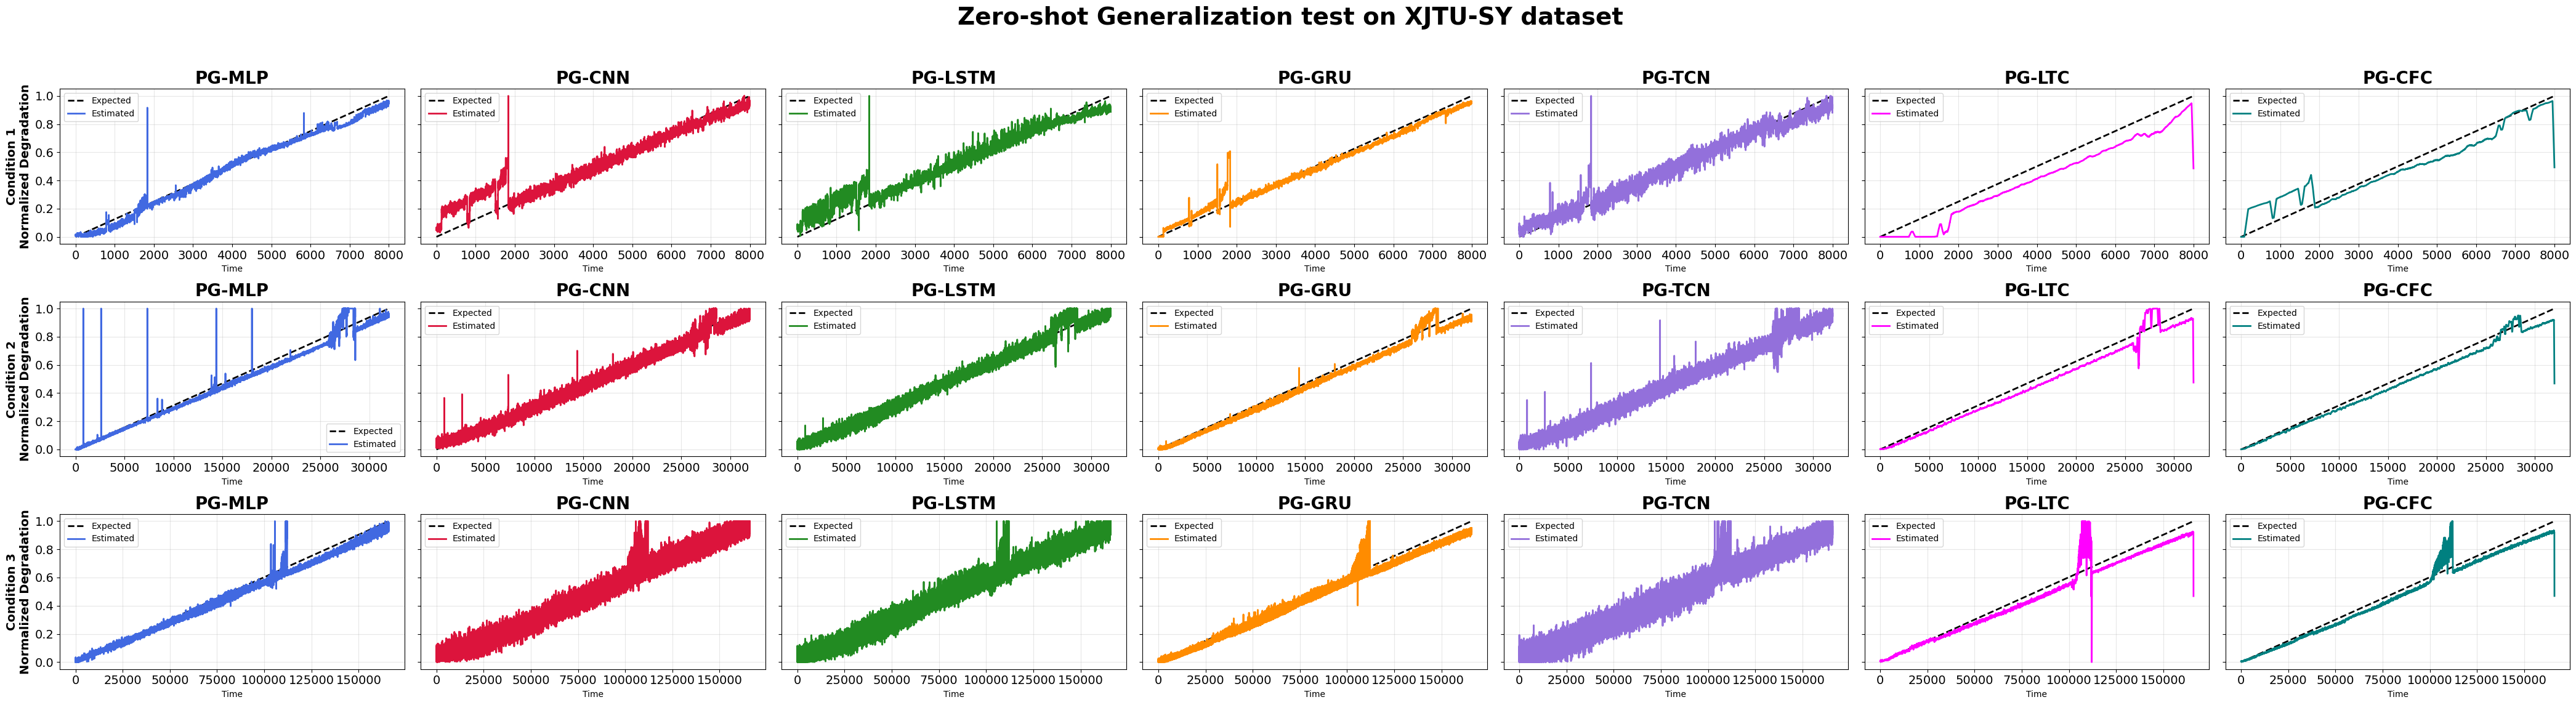

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from models.PGNN import PGNN
from networks.networks import cfc_network,ltc_network,tcn_network,lstm_network,gru_network,cnn_network,mlp_network
from utils.preprocess import process_features,moving_average  # This should handle 1D time series features
from utils.metrics import score_function


plt.style.use('seaborn-v0_8-deep')

# --- GLOBAL MATPLOTLIB STYLE SETTINGS ---
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# Selected bearings and metadata
selected_bearings = [
    {'condition': 'Condition 1', 'bearing': 'Bearing1_1', 'failure': 'Outer'},
    {'condition': 'Condition 2', 'bearing': 'Bearing2_1', 'failure': 'Inner'},
    {'condition': 'Condition 3', 'bearing': 'Bearing3_1', 'failure': 'No Failure'}
]

# Directories
root_dir = os.getcwd()
feature_dir = os.path.join(root_dir, 'tf_features_xjtu')
weights_dir = os.path.join(root_dir, 'model_weights')
stat_dir = os.path.join(root_dir, 'statistics')
plots_dir = os.path.join(root_dir, 'bearing_plots')

# Load models
pi_cfc = PGNN(cfc_network)
pi_cfc.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))
pi_cfc.name = "PG-CFC"

pi_ltc = PGNN(ltc_network)
pi_ltc.load_weights(os.path.join(weights_dir, 'PI_LTC.keras'))
pi_ltc.name = "PG-LTC"

pi_tcn = PGNN(tcn_network)
pi_tcn.load_weights(os.path.join(weights_dir, 'PI_TCN.keras'))
pi_tcn.name = "PG-TCN"

pi_lstm = PGNN(lstm_network)
pi_lstm.load_weights(os.path.join(weights_dir, 'PI_LSTM.keras'))
pi_lstm.name = "PG-LSTM"

pi_gru = PGNN(gru_network)
pi_gru.load_weights(os.path.join(weights_dir, 'PI_GRU.keras'))
pi_gru.name = "PG-GRU"

pi_cnn = PGNN(cnn_network)
pi_cnn.load_weights(os.path.join(weights_dir, 'PI_CNN.keras'))
pi_cnn.name = "PG-CNN"

pi_mlp = PGNN(mlp_network)
pi_mlp.load_weights(os.path.join(weights_dir, 'PI_MLP.keras'))
pi_mlp.name = "PG-MLP"

models = [pi_mlp, pi_cnn, pi_lstm, pi_gru, pi_tcn, pi_ltc, pi_cfc]
colors = ['royalblue', 'crimson', 'forestgreen', 'darkorange', 'mediumpurple', 'magenta', 'teal']

# Plot grid setup
num_conditions = len(selected_bearings)
num_models = len(models)

plt.style.use('seaborn-v0_8-deep')
fig, axes = plt.subplots(num_conditions, num_models, figsize=(6 * num_models, 4 * num_conditions), sharey=True)
fig.suptitle(r"Zero-shot Generalization test on XJTU-SY dataset", fontsize=28, fontweight='bold')

if num_conditions == 1:
    axes = np.expand_dims(axes, axis=0)
if num_models == 1:
    axes = np.expand_dims(axes, axis=1)

results = []  # Collect metrics for CSV output

# Loop through conditions and models
for i, bearing_info in enumerate(selected_bearings):
    condition = bearing_info['condition']
    bearing_name = bearing_info['bearing']

    # Load features
    csv_path = os.path.join(feature_dir, f'{bearing_name}_features_with_labels.csv')
    df = pd.read_csv(csv_path)

    # Process features
    xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
    xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
    vibration_features = np.concatenate((xh, xv), axis=-1)

    # Time and temperature
    t_data = np.array(df['Time'].values).reshape(-1, 1)
    T_data = np.full((xh.shape[0], 1), 298.15).reshape(-1, 1)  # Assuming constant temperature for zero-shot

    # Full input
    X = np.concatenate([vibration_features, t_data, T_data], axis=1)

    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    for j, model in enumerate(models):
        y_pred = model.predict(X)
        y_pred = np.clip(y_pred, 0, 1).flatten()
        expected_degradation = np.linspace(0, 1, len(y_pred))


        # Metrics
        # rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        # mae = mean_absolute_error(y_true, y_pred)
        # score = score_function(y_true, y_pred).numpy()

        # Save metrics
        # results.append({
        #     'Condition': condition,
        #     'Bearing': bearing_name,
        #     'Model': model.name,
        #     'RMSE': rmse,
        #     'MAE': mae,
        #     'Score': score
        # })

        # Plotting
        ax = axes[i, j]
        ax.plot(expected_degradation, label='Expected', color='black', linestyle='--', linewidth=2)
        if model.name == "PG-CFC" or model.name == "PG-LTC":
            ax.plot(moving_average(y_pred), label='Estimated',  color=colors[j], linewidth=2)
        else:
            ax.plot(y_pred, label='Estimated',  color=colors[j], linewidth=2)
        ax.set_title(f"{model.name}", fontsize=20, fontweight='bold')
        ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel(f"{condition}\nNormalized Degradation", fontsize=14, fontweight='bold')
        ax.grid(True,alpha=0.3)
        ax.legend()

# Final layout and save
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"{plots_dir}/PGLNS_zero_shot_generalization_plot.png", dpi=600)
plt.show()

# Save metrics to CSV
# results_df = pd.DataFrame(results)
# results_df.to_csv(f"{stat_dir}/PGLNS_zero_shot_model_performance_metrics.csv", index=False)


Model size and comparison

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

plots_dir = os.path.join(root_dir, 'bearing_plots')

plt.style.use('seaborn-v0_8-deep')

# -----------------------------
# Data
# -----------------------------
models = ['PI-MLP', 'PI-CNN', 'PI-LSTM', 'PI-GRU', 'PI-TCN', 'PI-LTC', 'PI_CFC']
params = [11041, 20465, 4697, 22729, 162769, 3434, 3128]
training = [4, 7, 13, 8, 16, 26, 15]
inference = [2, 3, 3, 3, 6, 3, 3]

x = np.arange(len(models))
width = 0.35

# -----------------------------
# Subplots setup
# -----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=600)

# -----------------------------
# Subplot (a): Parameters
# -----------------------------
bars1 = ax1.bar(x, params, color='skyblue', edgecolor='black')
ax1.set_title('(a) Size Comparison ', fontweight='bold')
ax1.set_ylabel('Parameters', fontsize=9, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:,}',
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=7)

# -----------------------------
# Subplot (b): Time
# -----------------------------
bars2_infer = ax2.bar(x - width/2, inference, width, label='Inference', color='skyblue', edgecolor='black')
bars2_train = ax2.bar(x + width/2, training, width, label='Training', color='orange', edgecolor='black')
ax2.set_title('(b) Time Analysis', fontweight='bold')
ax2.set_ylabel('Time (ms)', fontsize=9, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(fontsize=7)

# Annotate
for bar, time in zip(bars2_infer, inference):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f'{time} ms', ha='center', va='bottom', fontsize=7)

for bar, time in zip(bars2_train, training):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f'{time} ms', ha='center', va='bottom', fontsize=7)

# -----------------------------
# Final layout and save
# -----------------------------
plt.tight_layout()
plt.savefig(f"{plots_dir}/PG-LNS_model_parameters_and_time.png", bbox_inches='tight', dpi=600)
plt.show()


NameError: name 'os' is not defined

Noise Rosbutness Evalulation

2025-08-10 21:26:29.649087: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 21:26:29.650003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 21:26:29.652803: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 21:26:29.660653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754832389.673793   24882 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754832389.67

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LTC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_TCN.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LSTM.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_GRU.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CNN.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_MLP.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 3m

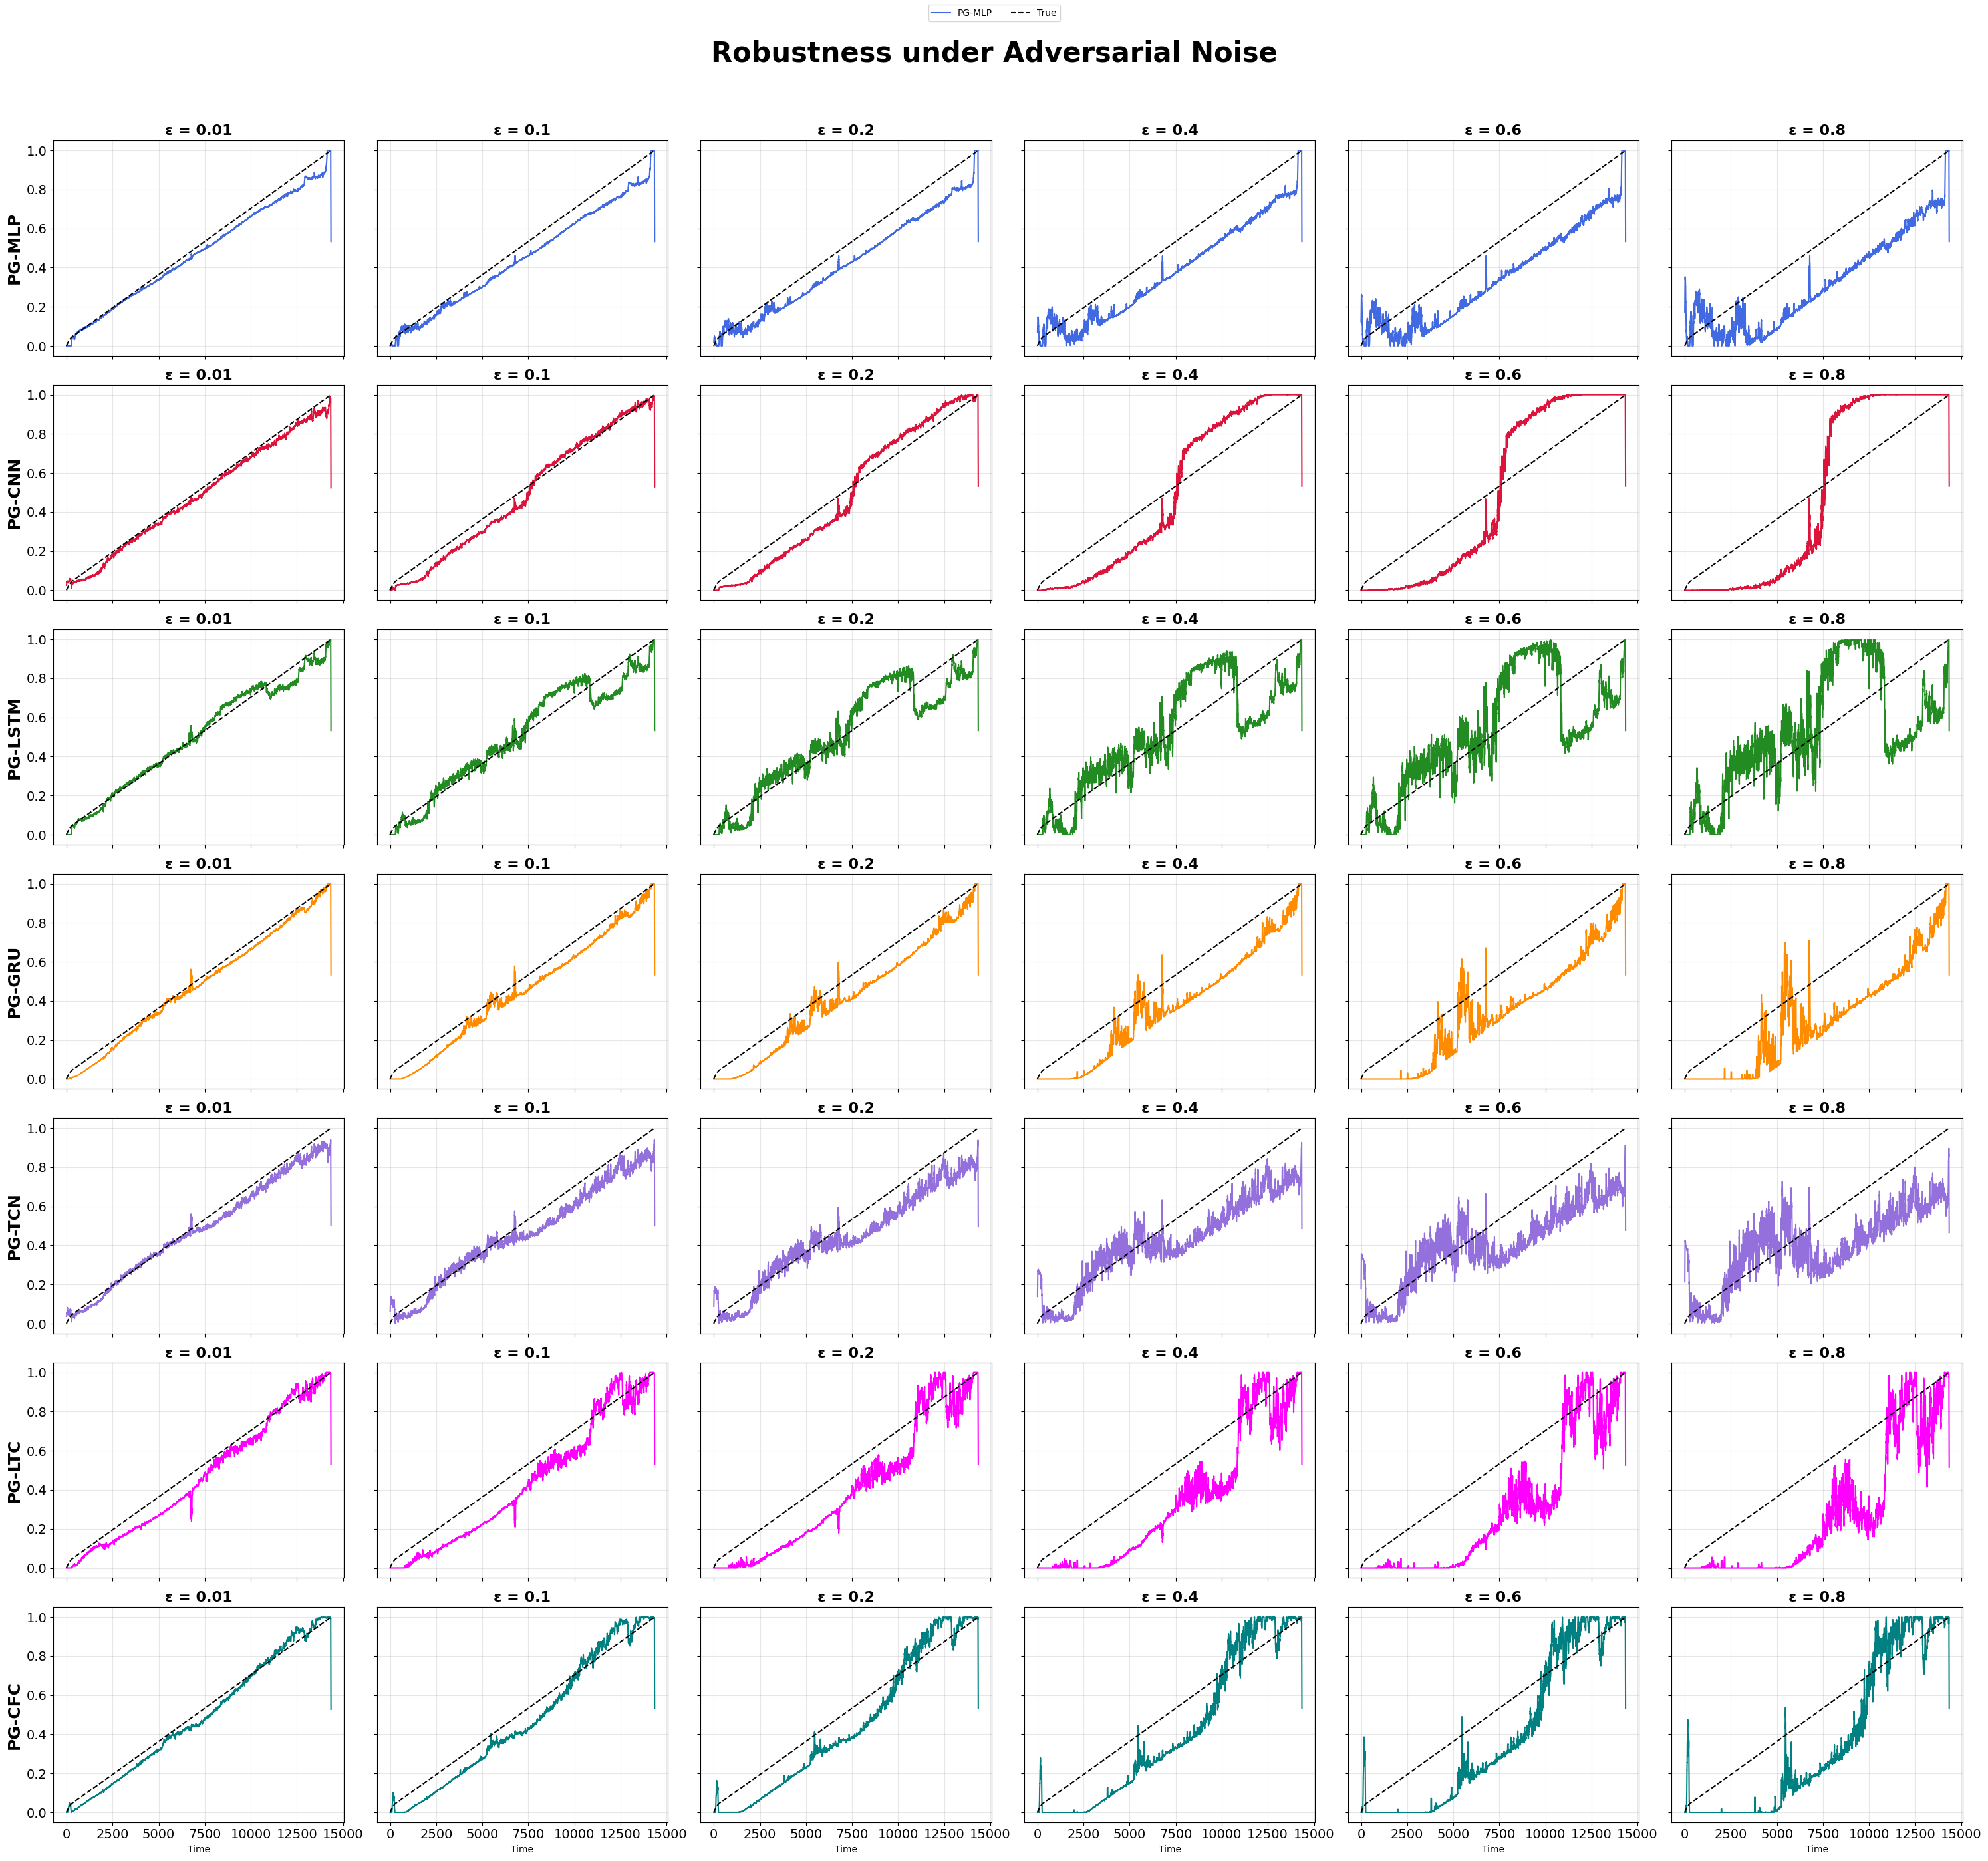

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras._tf_keras.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from models.PGNN import PGNN
from networks.networks import cfc_network,ltc_network,tcn_network,lstm_network,gru_network,cnn_network,mlp_network
from utils.preprocess import process_features,moving_average  # This should handle 1D time series features
from utils.metrics import score_function

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Set up
plt.style.use('seaborn-v0_8-deep')
root_dir = os.getcwd()
feature_dir = os.path.join(root_dir, 'tf_features')
weights_dir = os.path.join(root_dir, 'model_weights')
save_dir = os.path.join(root_dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

bearings = {
    '100Hz4kN': [{'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'}]
}

epsilon_values = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8]
mse = MeanSquaredError()

pi_cfc = PGNN(cfc_network)
pi_cfc.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))
pi_cfc.name = "PG-CFC"

pi_ltc = PGNN(ltc_network)
pi_ltc.load_weights(os.path.join(weights_dir, 'PI_LTC.keras'))
pi_ltc.name = "PG-LTC"

pi_tcn = PGNN(tcn_network)
pi_tcn.load_weights(os.path.join(weights_dir, 'PI_TCN.keras'))
pi_tcn.name = "PG-TCN"

pi_lstm = PGNN(lstm_network)
pi_lstm.load_weights(os.path.join(weights_dir, 'PI_LSTM.keras'))
pi_lstm.name = "PG-LSTM"

pi_gru = PGNN(gru_network)
pi_gru.load_weights(os.path.join(weights_dir, 'PI_GRU.keras'))
pi_gru.name = "PG-GRU"

pi_cnn = PGNN(cnn_network)
pi_cnn.load_weights(os.path.join(weights_dir, 'PI_CNN.keras'))
pi_cnn.name = "PG-CNN"

pi_mlp = PGNN(mlp_network)
pi_mlp.load_weights(os.path.join(weights_dir, 'PI_MLP.keras'))
pi_mlp.name = "PG-MLP"

models = {
    'PG-MLP': pi_mlp,
    'PG-CNN': pi_cnn,
    'PG-LSTM': pi_lstm,
    'PG-GRU': pi_gru,
    'PG-TCN': pi_tcn,
    'PG-LTC': pi_ltc,
    'PG-CFC': pi_cfc,
}


colors = {
    'PG-MLP': 'royalblue',
    'PG-CNN': 'crimson',
    'PG-LSTM': 'forestgreen',
    'PG-GRU': 'darkorange',
    'PG-TCN': 'mediumpurple',
    'PG-LTC': 'magenta',
    'PG-CFC': 'teal',
}



def fgsm(model, input_image, input_label, epsilon):
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_label = tf.cast(input_label, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        pred = model.model(input_image)
        loss = mse(input_label, pred)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adv = input_image + epsilon * signed_grad
    adv = tf.clip_by_value(adv, -5.0, 5.0)
    return adv


# Main loop
for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        bearing_name = bearing['name']
        try:
            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))
            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            y_true = np.array(df['Degradation'].values)

            n_models = len(models)
            n_epsilons = len(epsilon_values)
            fig, ax = plt.subplots(n_models, n_epsilons, figsize=(5 * n_epsilons, 4 * n_models), sharex=True, sharey=True)
            fig.suptitle(f"Robustness under Adversarial Noise", fontsize=30, fontweight='bold')

            model_names = list(models.keys())

            for row_idx, model_name in enumerate(model_names):
                model = models[model_name]
                for col_idx, eps in enumerate(epsilon_values):
                    try:
                        X_input = X_scaled

                        X_adv = fgsm(model, X_input, y_true, epsilon=eps).numpy()
                        y_pred = model.predict(X_adv).flatten()
                        y_pred = np.clip(y_pred, 0, 1)

                        ax[row_idx, col_idx].plot(moving_average(y_pred,window_size=30), label=model_name, color=colors[model_name])
                        ax[row_idx, col_idx].plot(y_true, label='True', color='black', linestyle='--')
                        ax[row_idx, col_idx].set_title(f"ε = {eps}", fontweight='bold',fontsize=16)

                        if col_idx == 0:
                            ax[row_idx, col_idx].set_ylabel(model_name, fontweight='bold', fontsize=18)
                        if row_idx == n_models - 1:
                            ax[row_idx, col_idx].set_xlabel('Time')

                        ax[row_idx, col_idx].grid(True, alpha=0.3)

                    except Exception as e:
                        print(f"Error with model {model_name} at eps={eps}: {e}")
                        ax[row_idx, col_idx].text(0.5, 0.5, 'Error', ha='center', va='center')
                        ax[row_idx, col_idx].set_title(f"ε = {eps}", fontweight='bold', fontsize=24)

            handles, labels = ax[0, 0].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', ncol=8, fontsize=10)
            fig.tight_layout(rect=[0, 0, 1, 0.96])

            fig_path = os.path.join(save_dir, f"PG_LNSRobustness_{bearing_name}_grid.png")
            # fig.savefig(fig_path)
            # plt.close(fig)
            # print(f"Saved plot for {bearing_name} → {fig_path}")

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")


PG-ELNS Test

2025-08-11 08:51:43.151382: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 08:51:43.152258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 08:51:43.154980: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 08:51:43.162708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754873503.175810   28685 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754873503.17

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_ELTC_01.hdf5.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_ELTC_05.hdf5.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_ELTC_10.hdf5.keras


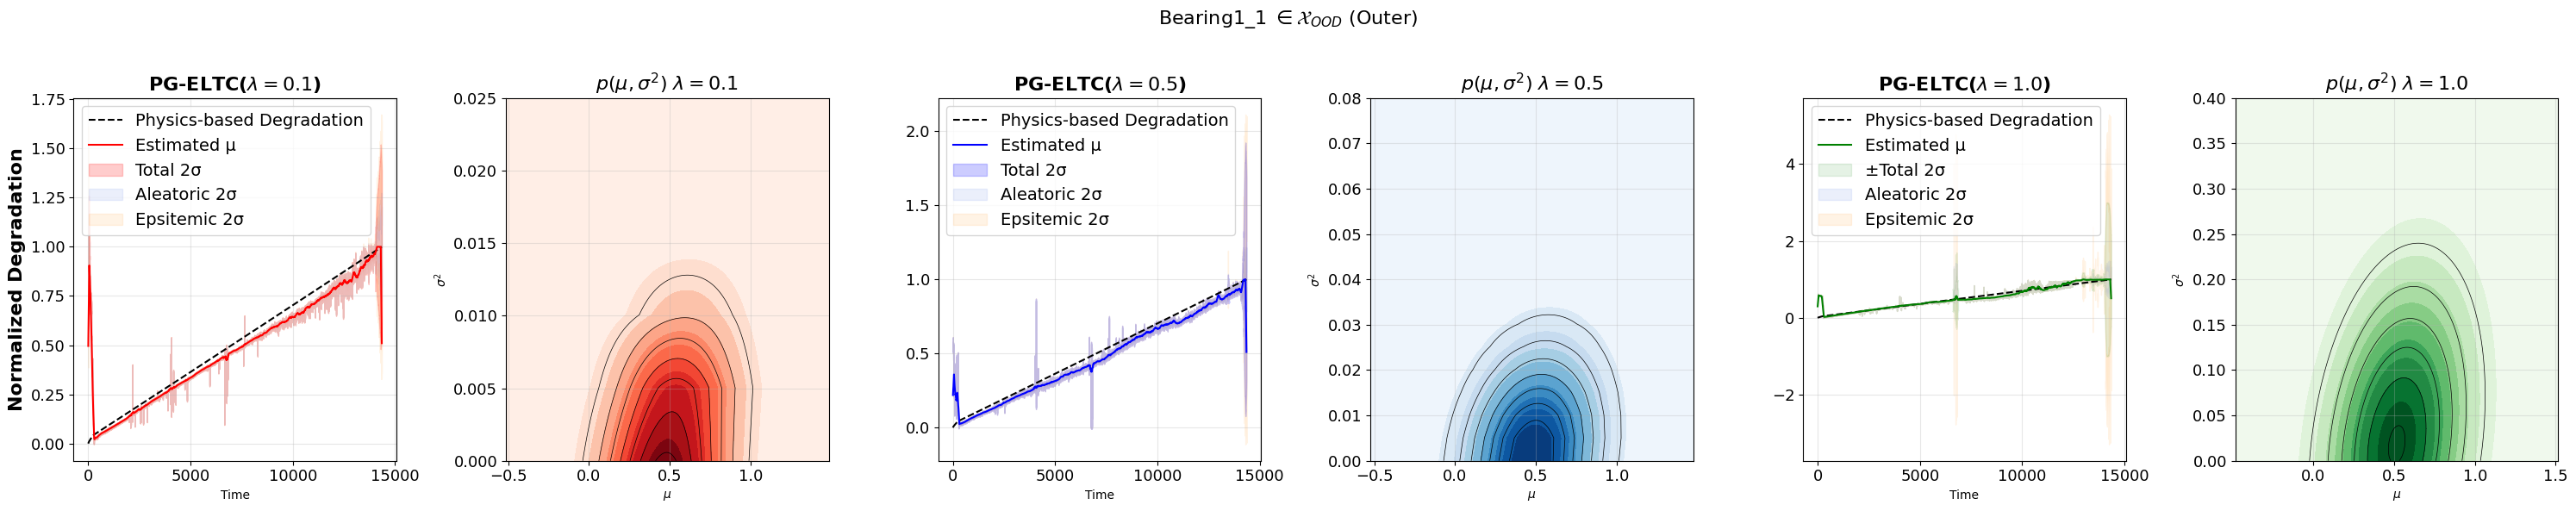

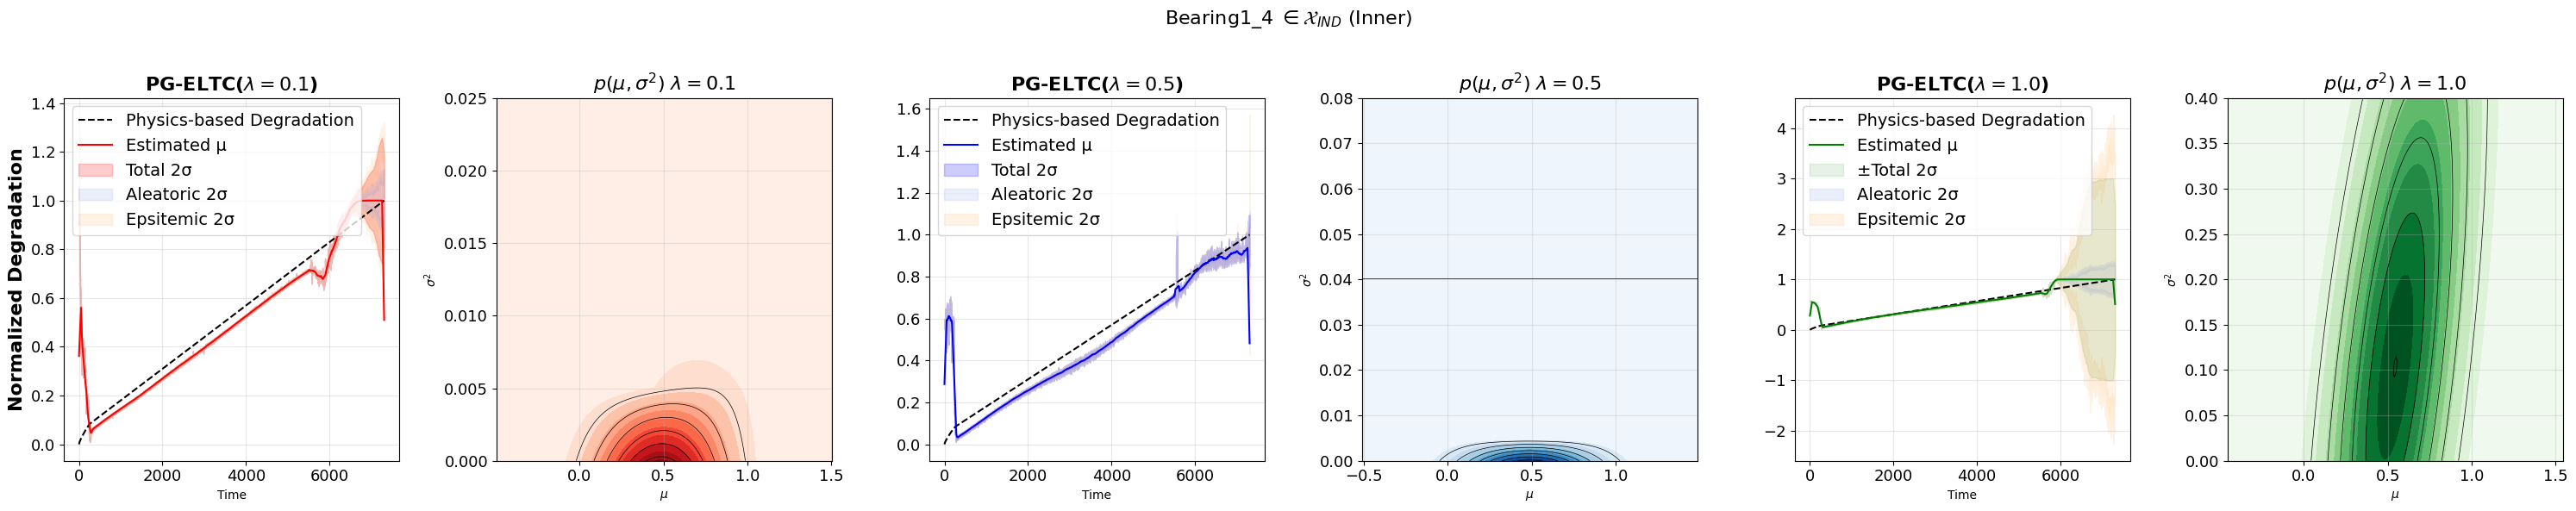

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.UQ_networks import eltc_network, ecfc_network
from models.UQ_SNER import UQ_SNER
from utils.preprocess import process_features, moving_average


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]}



def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylabel(r'$\sigma^2$')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sner_02 = UQ_SNER(eltc_network, lambbda=0.1)
sner_02.load_weights(os.path.join(weights_dir, 'PI_ELTC_01.hdf5.keras'))

sner_05 = UQ_SNER(eltc_network, lambbda=0.5)
sner_05.load_weights(os.path.join(weights_dir, 'PI_ELTC_05.hdf5.keras'))

sner_1 = UQ_SNER(eltc_network, lambbda=1.0)
sner_1.load_weights(os.path.join(weights_dir, 'PI_ELTC_10.hdf5.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---

color_aleatoric = 'royalblue'
color_epistemic = 'darkorange'
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mu_05, aleatoric_05, epistemic_05, total_05 = sner_02._predict(X)

            mu_1, aleatoric_1, epistemic_1, total_1 = sner_05._predict(X)

            mu_2, aleatoric_2, epistemic_2, total_2 = sner_1._predict(X)
            
            mu_05 = np.clip(mu_05, 0, 1)
            total_05 = np.clip(total_05, 0, 1)
            mu_1 = np.clip(mu_1, 0, 1)
            total_1 = np.clip(total_1, 0, 1)
            mu_2 = np.clip(mu_2, 0, 1)
            total_2 = np.clip(total_2, 0, 1)

            sngp_05_var = moving_average(total_05)
            sngp_1_var = moving_average(total_1)
            sngp_2_var = moving_average(total_2)

            ma_05 = moving_average(mu_05)
            ma_1 = moving_average(mu_1)
            ma_2 = moving_average(mu_2)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=16)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, mu_05 - 2*std_05, mu_05 + 2*std_05, color='red', alpha=0.2, label=r'Total 2σ')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(aleatoric_05), mu_05+2*np.sqrt(aleatoric_05), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(epistemic_05), mu_05+2*np.sqrt(epistemic_05), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[0].set_title(r"PG-ELTC($\lambda=0.1$)", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=16, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(mu_05, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.1$", fontsize=16, fontweight='bold')
            ax[1].set_ylim(0, 0.025)


            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, mu_1 - 2*std_1, mu_1 + 2*std_1, color='blue', alpha=0.2, label=r'Total 2σ')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(aleatoric_1), mu_1+2*np.sqrt(aleatoric_1), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(epistemic_1), mu_1+2*np.sqrt(epistemic_1), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[2].set_title(r"PG-ELTC($\lambda=0.5$)", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)


            # γ = 1.0 posterior
            plot_contour(mu_1, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.5$", fontsize=16, fontweight='bold')
            ax[3].set_ylim(0, 0.08)


            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, mu_2 - 2*std_2, mu_2 + 2*std_2, color='green', alpha=0.1, label=r'±Total 2σ')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(aleatoric_2), mu_2+2*np.sqrt(aleatoric_2), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(epistemic_2), mu_2+2*np.sqrt(epistemic_2), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[4].set_title(r"PG-ELTC($\lambda=1.0$)", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(mu_2, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ \lambda=1.0$", fontsize=16, fontweight='bold')
            ax[5].set_ylim(0, 0.40)


            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'PGELTC_{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_ECFC_01.hdf5.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_ECFC_05.hdf5.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_ECFC_10.hdf5.keras


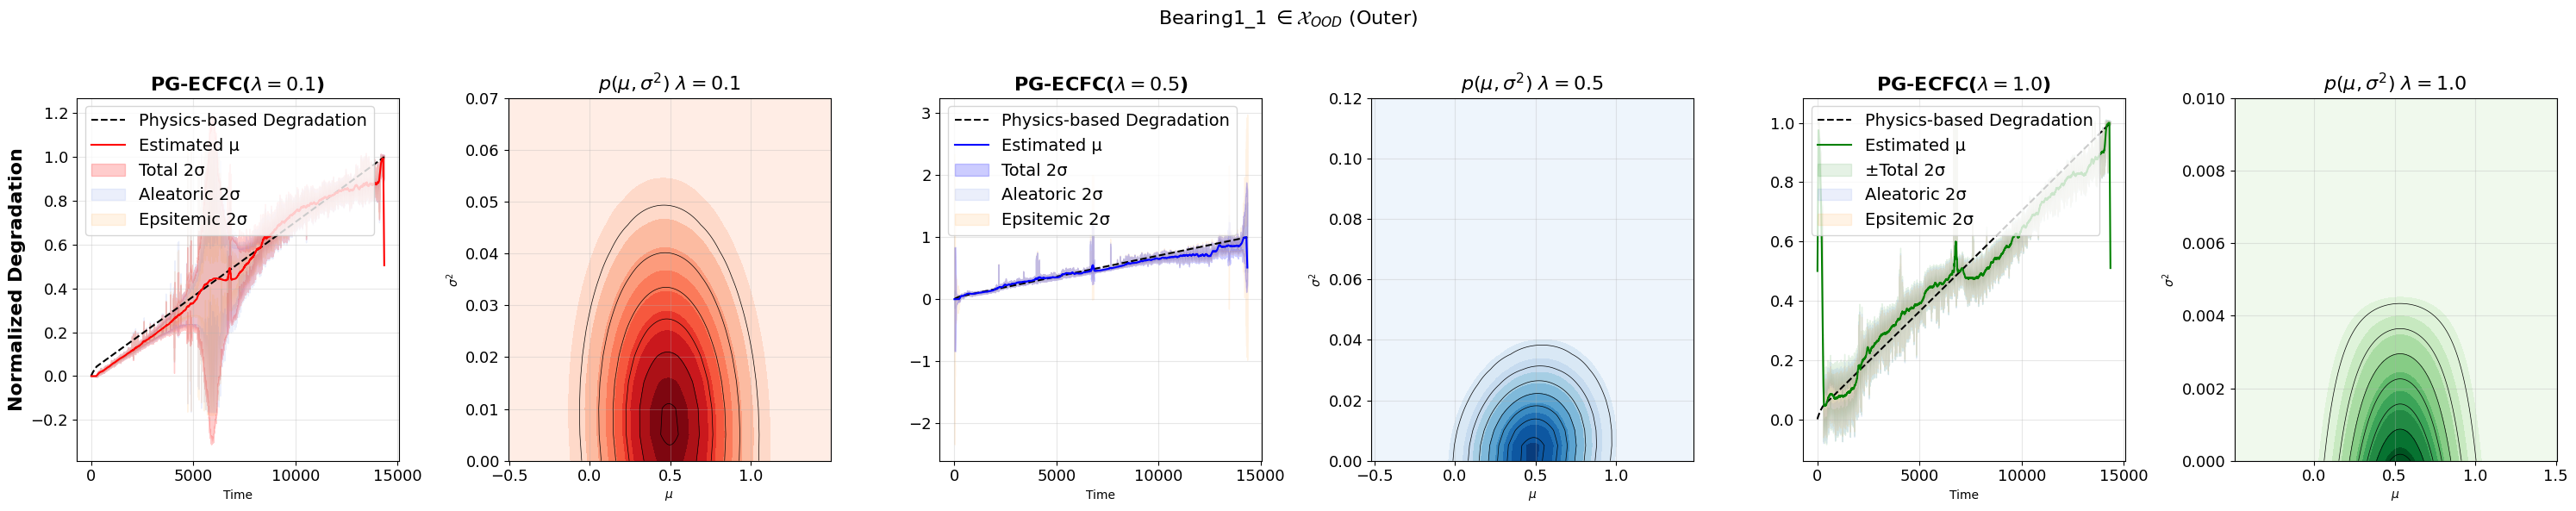

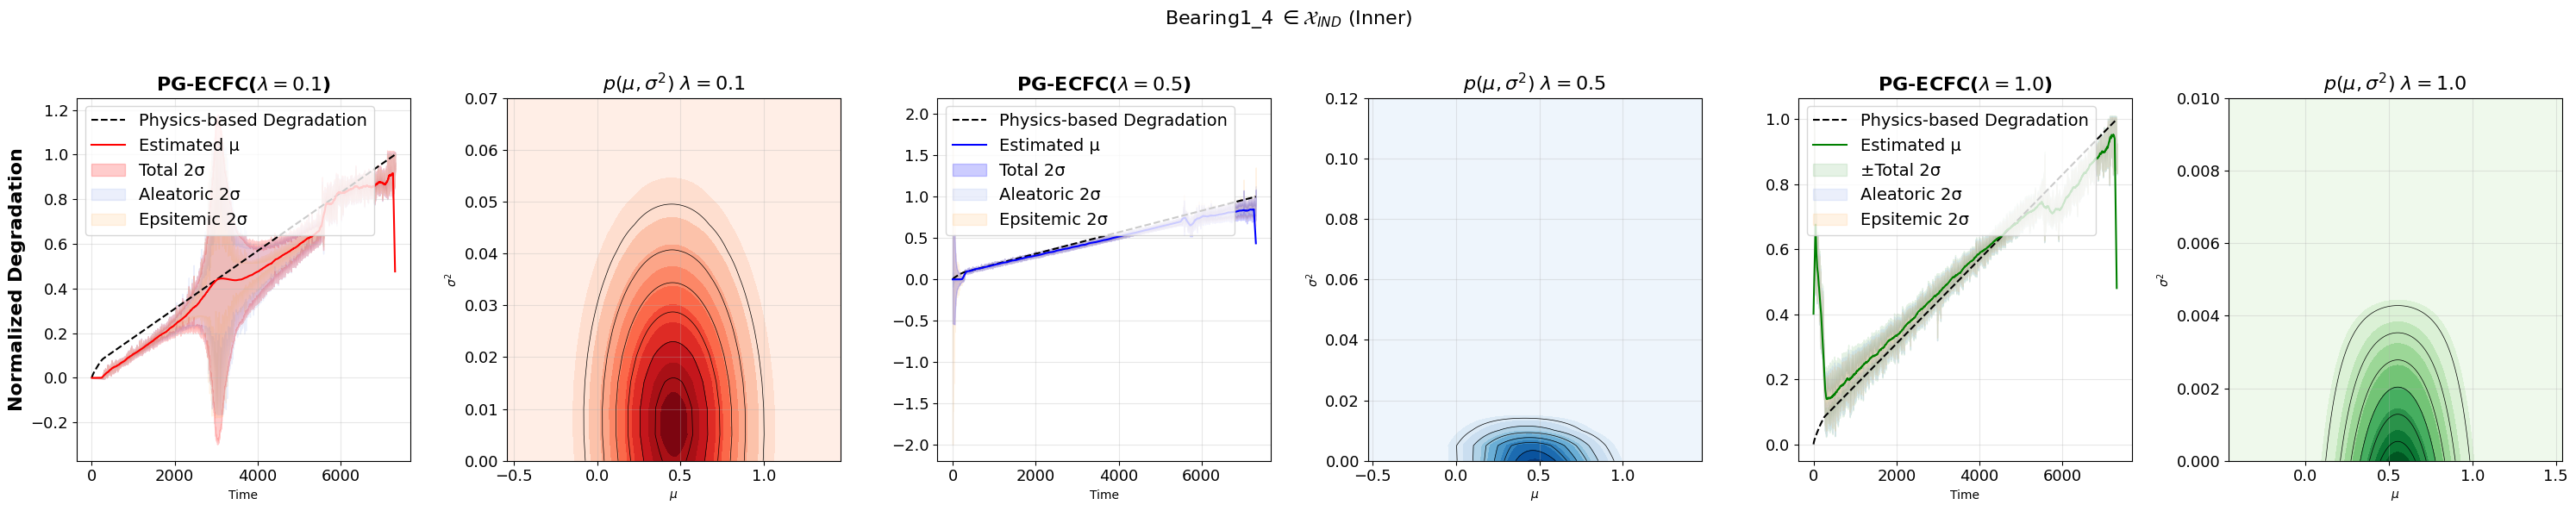

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.UQ_networks import eltc_network, ecfc_network
from models.UQ_SNER import UQ_SNER
from utils.preprocess import process_features, moving_average


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]}



def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylabel(r'$\sigma^2$')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sner_02 = UQ_SNER(ecfc_network, lambbda=0.1)
sner_02.load_weights(os.path.join(weights_dir, 'PI_ECFC_01.hdf5.keras'))

sner_05 = UQ_SNER(ecfc_network, lambbda=0.5)
sner_05.load_weights(os.path.join(weights_dir, 'PI_ECFC_05.hdf5.keras'))

sner_1 = UQ_SNER(ecfc_network, lambbda=1.0)
sner_1.load_weights(os.path.join(weights_dir, 'PI_ECFC_10.hdf5.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---

color_aleatoric = 'royalblue'
color_epistemic = 'darkorange'
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mu_05, aleatoric_05, epistemic_05, total_05 = sner_02._predict(X)

            mu_1, aleatoric_1, epistemic_1, total_1 = sner_05._predict(X)

            mu_2, aleatoric_2, epistemic_2, total_2 = sner_1._predict(X)
            
            mu_05 = np.clip(mu_05, 0, 1)
            total_05 = np.clip(total_05, 0, 1)
            mu_1 = np.clip(mu_1, 0, 1)
            total_1 = np.clip(total_1, 0, 1)
            mu_2 = np.clip(mu_2, 0, 1)
            total_2 = np.clip(total_2, 0, 1)

            sngp_05_var = moving_average(total_05)
            sngp_1_var = moving_average(total_1)
            sngp_2_var = moving_average(total_2)

            ma_05 = moving_average(mu_05)
            ma_1 = moving_average(mu_1)
            ma_2 = moving_average(mu_2)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=16)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, mu_05 - 2*std_05, mu_05 + 2*std_05, color='red', alpha=0.2, label=r'Total 2σ')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(aleatoric_05), mu_05+2*np.sqrt(aleatoric_05), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(epistemic_05), mu_05+2*np.sqrt(epistemic_05), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[0].set_title(r"PG-ECFC($\lambda=0.1$)", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=16, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(mu_05, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.1$", fontsize=16, fontweight='bold')
            ax[1].set_ylim(0, 0.07)


            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, mu_1 - 2*std_1, mu_1 + 2*std_1, color='blue', alpha=0.2, label=r'Total 2σ')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(aleatoric_1), mu_1+2*np.sqrt(aleatoric_1), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(epistemic_1), mu_1+2*np.sqrt(epistemic_1), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[2].set_title(r"PG-ECFC($\lambda=0.5$)", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)


            # γ = 1.0 posterior
            plot_contour(mu_1, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.5$", fontsize=16, fontweight='bold')
            ax[3].set_ylim(0, 0.12)


            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, mu_2 - 2*std_2, mu_2 + 2*std_2, color='green', alpha=0.1, label=r'±Total 2σ')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(aleatoric_2), mu_2+2*np.sqrt(aleatoric_2), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(epistemic_2), mu_2+2*np.sqrt(epistemic_2), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[4].set_title(r"PG-ECFC($\lambda=1.0$)", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(mu_2, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ \lambda=1.0$", fontsize=16, fontweight='bold')
            ax[5].set_ylim(0, 0.01)


            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'PGECFC_{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LTC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LTC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_LTC.keras


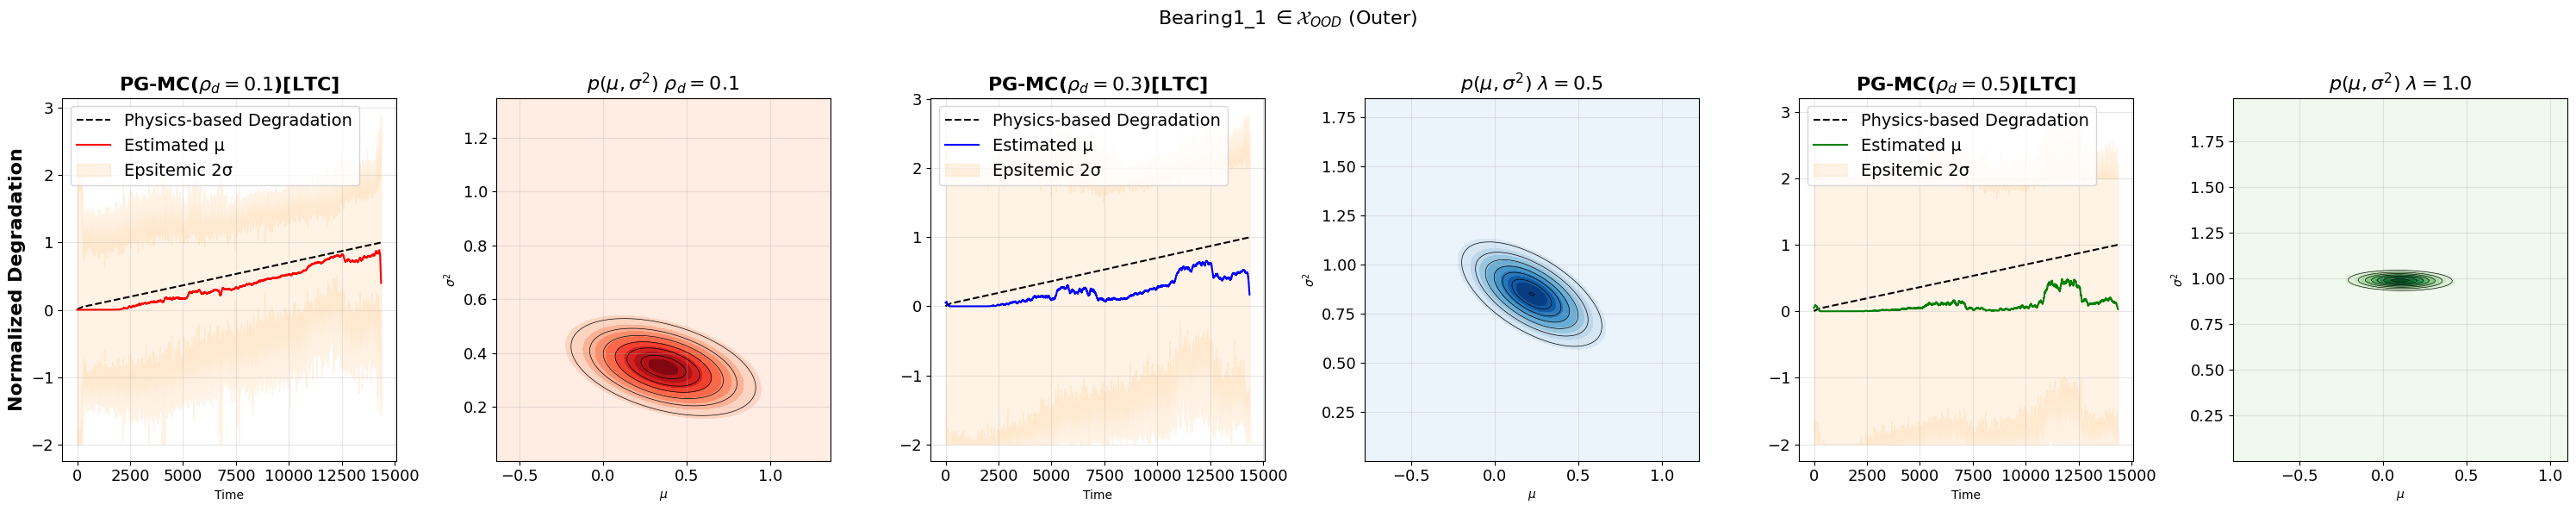

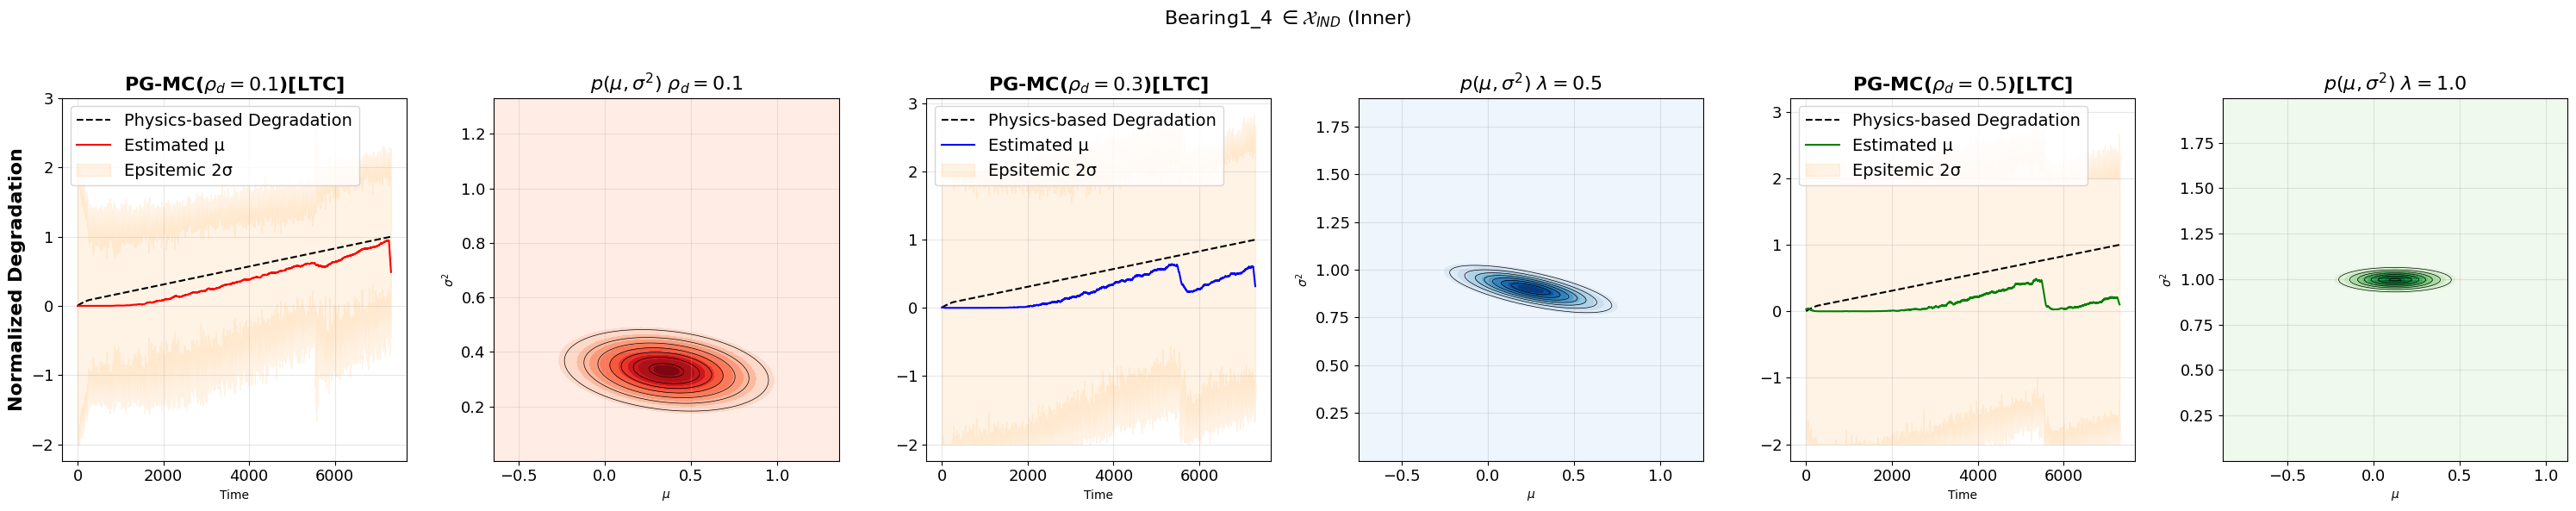

In [3]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.UQ_networks import ltc_network, cfc_network
from models.UQ_SNER import UQ_SNER
from models.UQ_MC import UQ_MC
from utils.preprocess import process_features, moving_average


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]}



def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylabel(r'$\sigma^2$')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sner_02 = UQ_MC(ltc_network, dropout_rate=0.1)
sner_02.load_weights(os.path.join(weights_dir, 'PI_LTC.keras'))

sner_05 = UQ_MC(ltc_network, dropout_rate=0.3)
sner_05.load_weights(os.path.join(weights_dir, 'PI_LTC.keras'))

sner_1 = UQ_MC(ltc_network, dropout_rate=0.5)
sner_1.load_weights(os.path.join(weights_dir, 'PI_LTC.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---

color_aleatoric = 'royalblue'
color_epistemic = 'darkorange'
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mu_05, total_05 = sner_02._predict(X)

            mu_1, total_1 = sner_05._predict(X)

            mu_2, total_2 = sner_1._predict(X)
            
            mu_05 = np.clip(mu_05, 0, 1)
            total_05 = np.clip(total_05, 0, 1)
            mu_1 = np.clip(mu_1, 0, 1)
            total_1 = np.clip(total_1, 0, 1)
            mu_2 = np.clip(mu_2, 0, 1)
            total_2 = np.clip(total_2, 0, 1)

            sngp_05_var = moving_average(total_05)
            sngp_1_var = moving_average(total_1)
            sngp_2_var = moving_average(total_2)

            ma_05 = moving_average(mu_05)
            ma_1 = moving_average(mu_1)
            ma_2 = moving_average(mu_2)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=16)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(total_05), mu_05+2*np.sqrt(total_05), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[0].set_title(r"PG-MC($\rho_d=0.1$)[LTC]", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=16, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(mu_05, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ \rho_d=0.1$", fontsize=16, fontweight='bold')


            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(total_1), mu_1+2*np.sqrt(total_1), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[2].set_title(r"PG-MC($\rho_d=0.3$)[LTC]", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)


            # γ = 1.0 posterior
            plot_contour(mu_1, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.5$", fontsize=16, fontweight='bold')


            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(total_2), mu_2+2*np.sqrt(total_2), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[4].set_title(r"PG-MC($\rho_d=0.5$)[LTC]", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(mu_2, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ \lambda=1.0$", fontsize=16, fontweight='bold')


            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'PGETC_MC_{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras


Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras


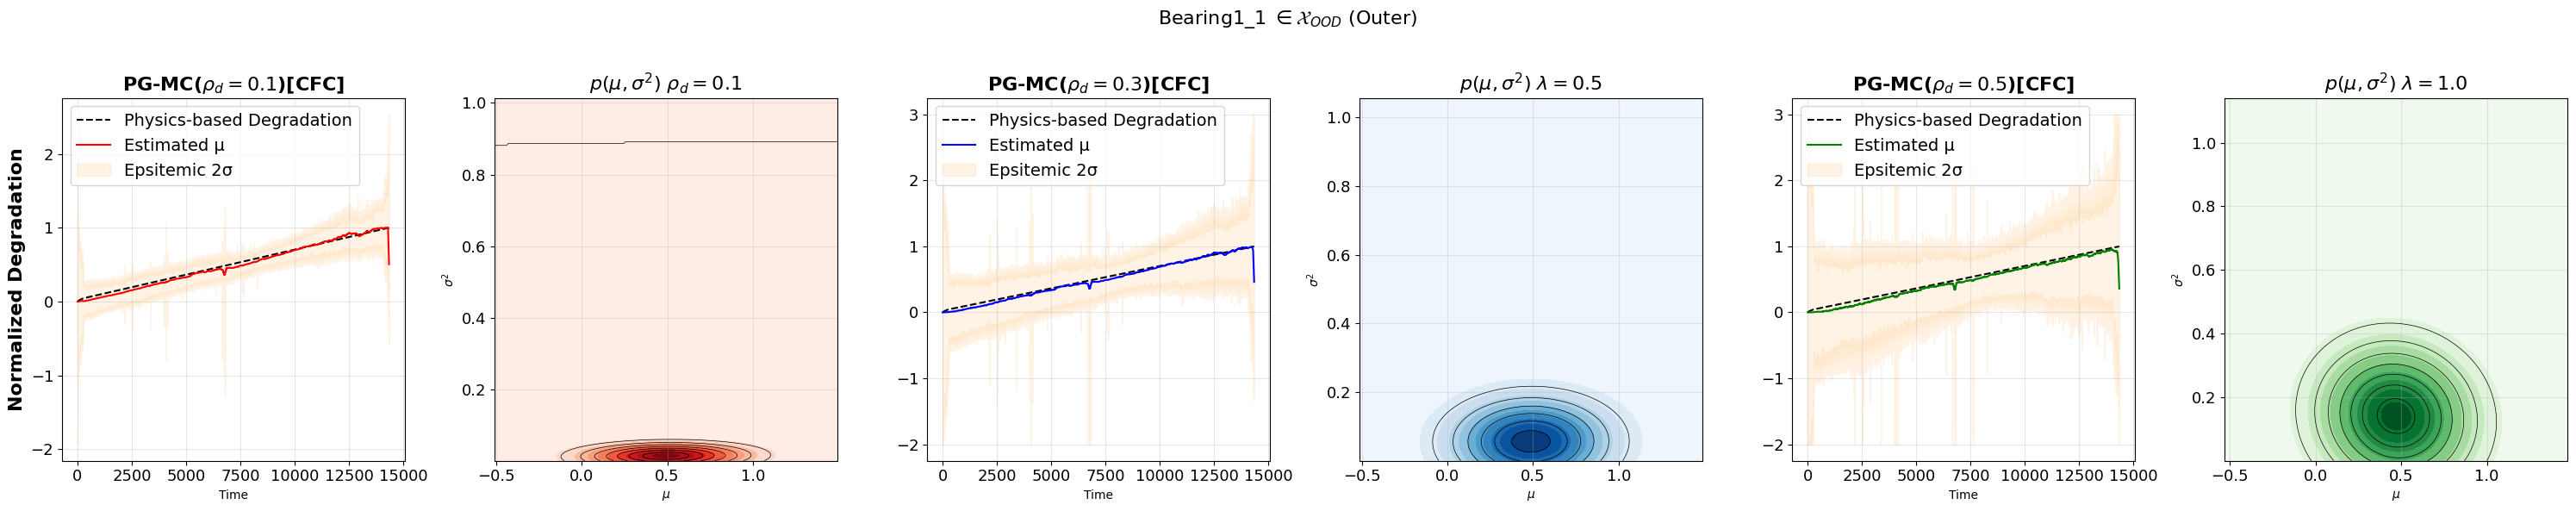

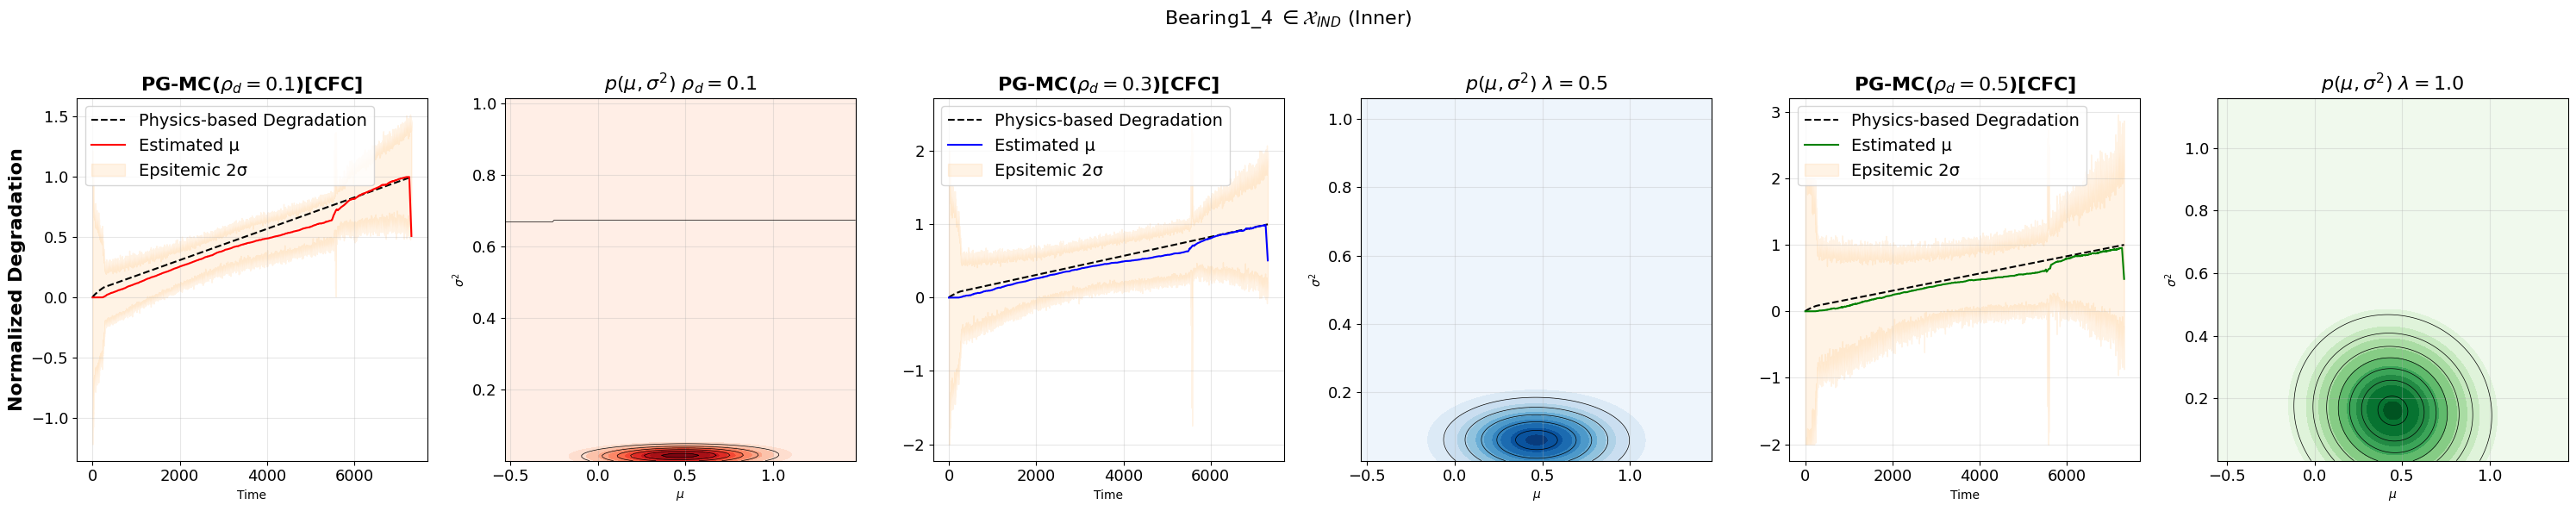

In [4]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.UQ_networks import ltc_network, cfc_network
from models.UQ_SNER import UQ_SNER
from models.UQ_MC import UQ_MC
from utils.preprocess import process_features, moving_average


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]}



def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylabel(r'$\sigma^2$')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sner_02 = UQ_MC(cfc_network, dropout_rate=0.1)
sner_02.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))

sner_05 = UQ_MC(cfc_network, dropout_rate=0.3)
sner_05.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))

sner_1 = UQ_MC(cfc_network, dropout_rate=0.5)
sner_1.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---

color_aleatoric = 'royalblue'
color_epistemic = 'darkorange'
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mu_05, total_05 = sner_02._predict(X)

            mu_1, total_1 = sner_05._predict(X)

            mu_2, total_2 = sner_1._predict(X)
            
            mu_05 = np.clip(mu_05, 0, 1)
            total_05 = np.clip(total_05, 0, 1)
            mu_1 = np.clip(mu_1, 0, 1)
            total_1 = np.clip(total_1, 0, 1)
            mu_2 = np.clip(mu_2, 0, 1)
            total_2 = np.clip(total_2, 0, 1)

            sngp_05_var = moving_average(total_05)
            sngp_1_var = moving_average(total_1)
            sngp_2_var = moving_average(total_2)

            ma_05 = moving_average(mu_05)
            ma_1 = moving_average(mu_1)
            ma_2 = moving_average(mu_2)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=16)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(total_05), mu_05+2*np.sqrt(total_05), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[0].set_title(r"PG-MC($\rho_d=0.1$)[CFC]", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=16, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(mu_05, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ \rho_d=0.1$", fontsize=16, fontweight='bold')


            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(total_1), mu_1+2*np.sqrt(total_1), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[2].set_title(r"PG-MC($\rho_d=0.3$)[CFC]", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)


            # γ = 1.0 posterior
            plot_contour(mu_1, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.5$", fontsize=16, fontweight='bold')


            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(total_2), mu_2+2*np.sqrt(total_2), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[4].set_title(r"PG-MC($\rho_d=0.5$)[CFC]", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(mu_2, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ \lambda=1.0$", fontsize=16, fontweight='bold')


            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'PGCFC_MC_{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras
Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_CFC.keras


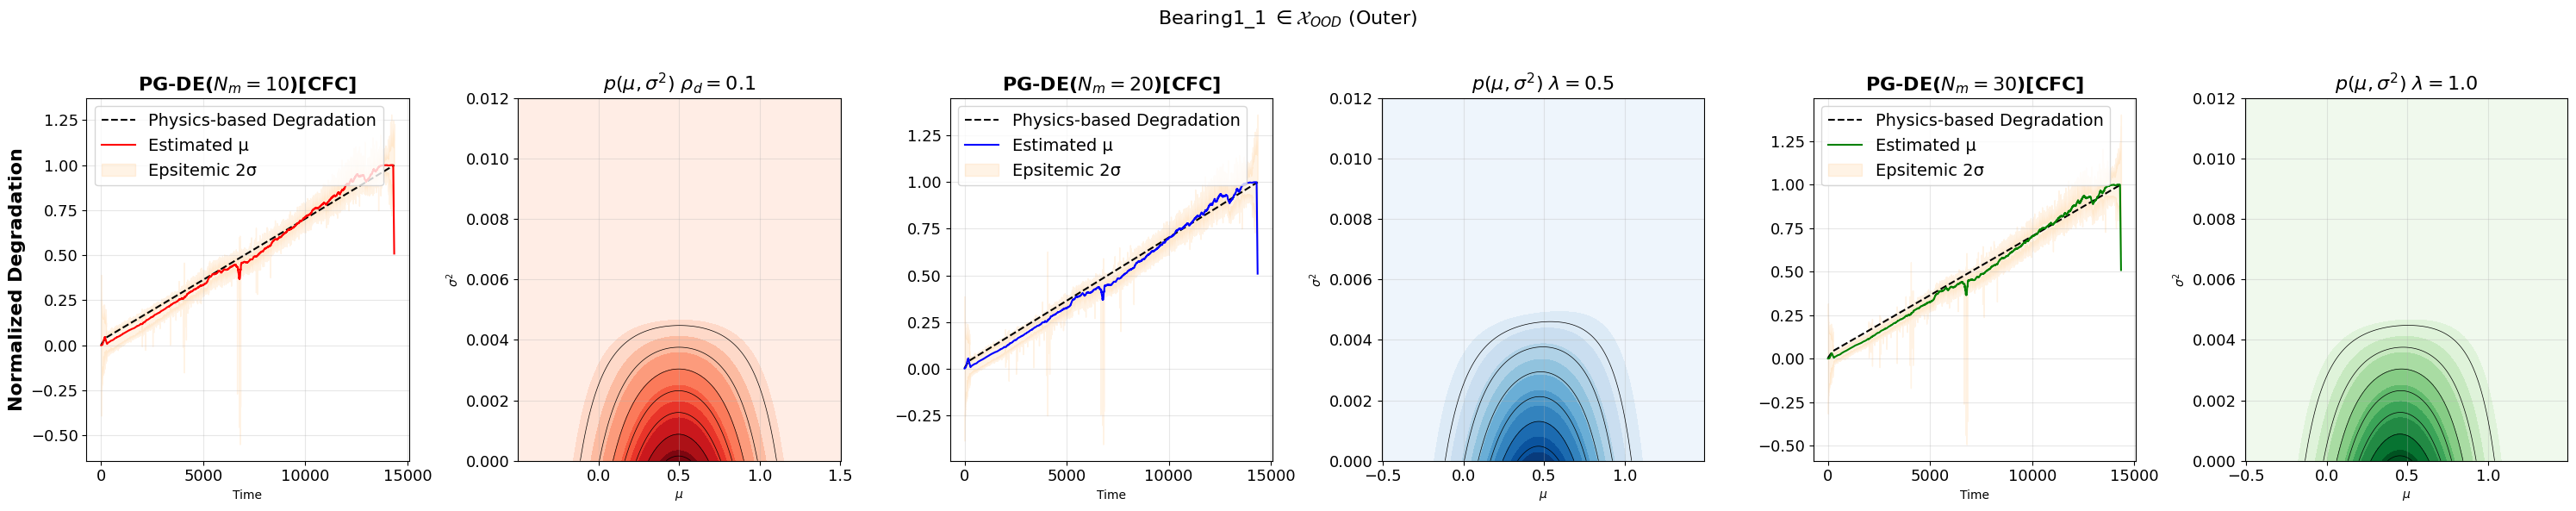

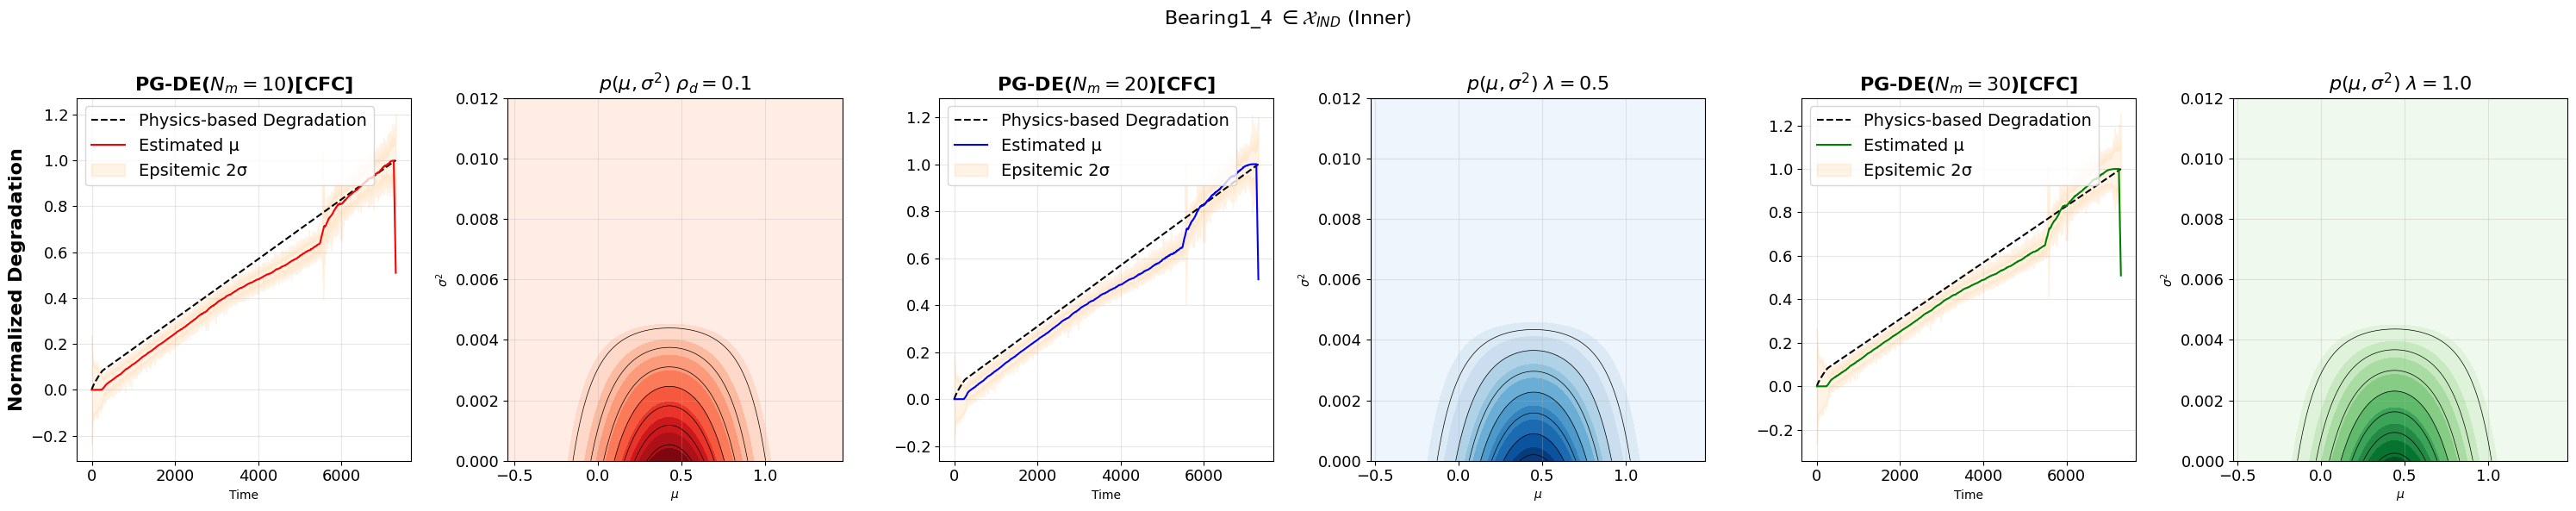

In [6]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from networks.networks import ltc_network, cfc_network
from models.UQ_SNER import UQ_SNER
from models.UQ_MC import UQ_MC
from models.UQ_DE import UQ_DE
from utils.preprocess import process_features, moving_average


plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner','data_dist':'IND'},
        
]}



def plot_contour(mu_values, var_values, ax,color):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap=color)
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$')
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylabel(r'$\sigma^2$')
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sner_02 = UQ_DE(cfc_network)
sner_02.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))

sner_05 = UQ_DE(cfc_network)
sner_05.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))

sner_1 = UQ_DE(cfc_network)
sner_1.load_weights(os.path.join(weights_dir, 'PI_CFC.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---

color_aleatoric = 'royalblue'
color_epistemic = 'darkorange'
plt.style.use('seaborn-v0_8-deep')

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mu_05, total_05 = sner_02._predict(X,num_models=10)

            mu_1, total_1 = sner_05._predict(X,num_models=20)

            mu_2, total_2 = sner_1._predict(X,num_models=30)
            
            mu_05 = np.clip(mu_05, 0, 1)
            total_05 = np.clip(total_05, 0, 1)
            mu_1 = np.clip(mu_1, 0, 1)
            total_1 = np.clip(total_1, 0, 1)
            mu_2 = np.clip(mu_2, 0, 1)
            total_2 = np.clip(total_2, 0, 1)

            sngp_05_var = moving_average(total_05)
            sngp_1_var = moving_average(total_1)
            sngp_2_var = moving_average(total_2)

            ma_05 = moving_average(mu_05)
            ma_1 = moving_average(mu_1)
            ma_2 = moving_average(mu_2)

            std_05 = np.sqrt(sngp_05_var)
            std_1 = np.sqrt(sngp_1_var)
            std_2 = np.sqrt(sngp_2_var)

            

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(rf"{bearing_name} $\in \mathcal{{X}}_{{{data_dist}}}$ ({failure_type})", fontsize=16)
            x_vals = np.arange(len(y_true))

            # γ = 0.5 prediction
            ax[0].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[0].plot(ma_05, label='Estimated μ', color='red')
            ax[0].fill_between(x_vals, mu_05-2*np.sqrt(total_05), mu_05+2*np.sqrt(total_05), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[0].set_title(r"PG-DE($N_m=10$)[CFC]", fontsize=16, fontweight='bold')
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(f"Normalized Degradation", fontsize=16, fontweight='bold')
            ax[0].legend(loc='upper left', fontsize=14)
            ax[0].grid(True, alpha=0.3)

            # γ = 0.5 posterior
            plot_contour(mu_05, sngp_05_var, ax[1],color='Reds')
            ax[1].set_title(r"$p(\mu,\sigma^2)\ \rho_d=0.1$", fontsize=16, fontweight='bold')
            ax[1].set_ylim(0, 0.012)


            # γ = 1.0 prediction
            ax[2].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[2].plot(ma_1, label='Estimated μ', color='blue')
            ax[2].fill_between(x_vals, mu_1-2*np.sqrt(total_1), mu_1+2*np.sqrt(total_1), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[2].set_title(r"PG-DE($N_m=20$)[CFC]", fontsize=16, fontweight='bold')
            ax[2].set_xlabel('Time')
            ax[2].legend(loc='upper left', fontsize=14)
            ax[2].grid(True, alpha=0.3)


            # γ = 1.0 posterior
            plot_contour(mu_1, sngp_1_var, ax[3],color='Blues')
            ax[3].set_title(r"$p(\mu,\sigma^2)\ \lambda=0.5$", fontsize=16, fontweight='bold')
            ax[3].set_ylim(0, 0.012)


            # γ = 2.0 prediction
            ax[4].plot(y_true, label='Physics-based Degradation', linestyle='--', color='black')
            ax[4].plot(ma_2, label='Estimated μ', color='green')
            ax[4].fill_between(x_vals, mu_2-2*np.sqrt(total_2), mu_2+2*np.sqrt(total_2), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
            ax[4].set_title(r"PG-DE($N_m=30$)[CFC]", fontsize=16, fontweight='bold')
            ax[4].set_xlabel('Time')
            ax[4].legend(loc='upper left', fontsize=14)
            ax[4].grid(True, alpha=0.3)

            # γ = 2.0 posterior
            plot_contour(mu_2, sngp_2_var, ax[5],color='Greens')
            ax[5].set_title(r"$p(\mu,\sigma^2)\ \lambda=1.0$", fontsize=16, fontweight='bold')
            ax[5].set_ylim(0, 0.012)


            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'PGCFC_DE_{bearing_name}.png'),dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Adversarial test

2025-08-11 09:32:02.892132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 09:32:02.893077: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 09:32:02.895895: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 09:32:02.903767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754875922.917078   14066 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754875922.92

Loaded weights from: /home/ustc15/research/phd_pgnn/model_weights/PI_ECFC_05.hdf5.keras


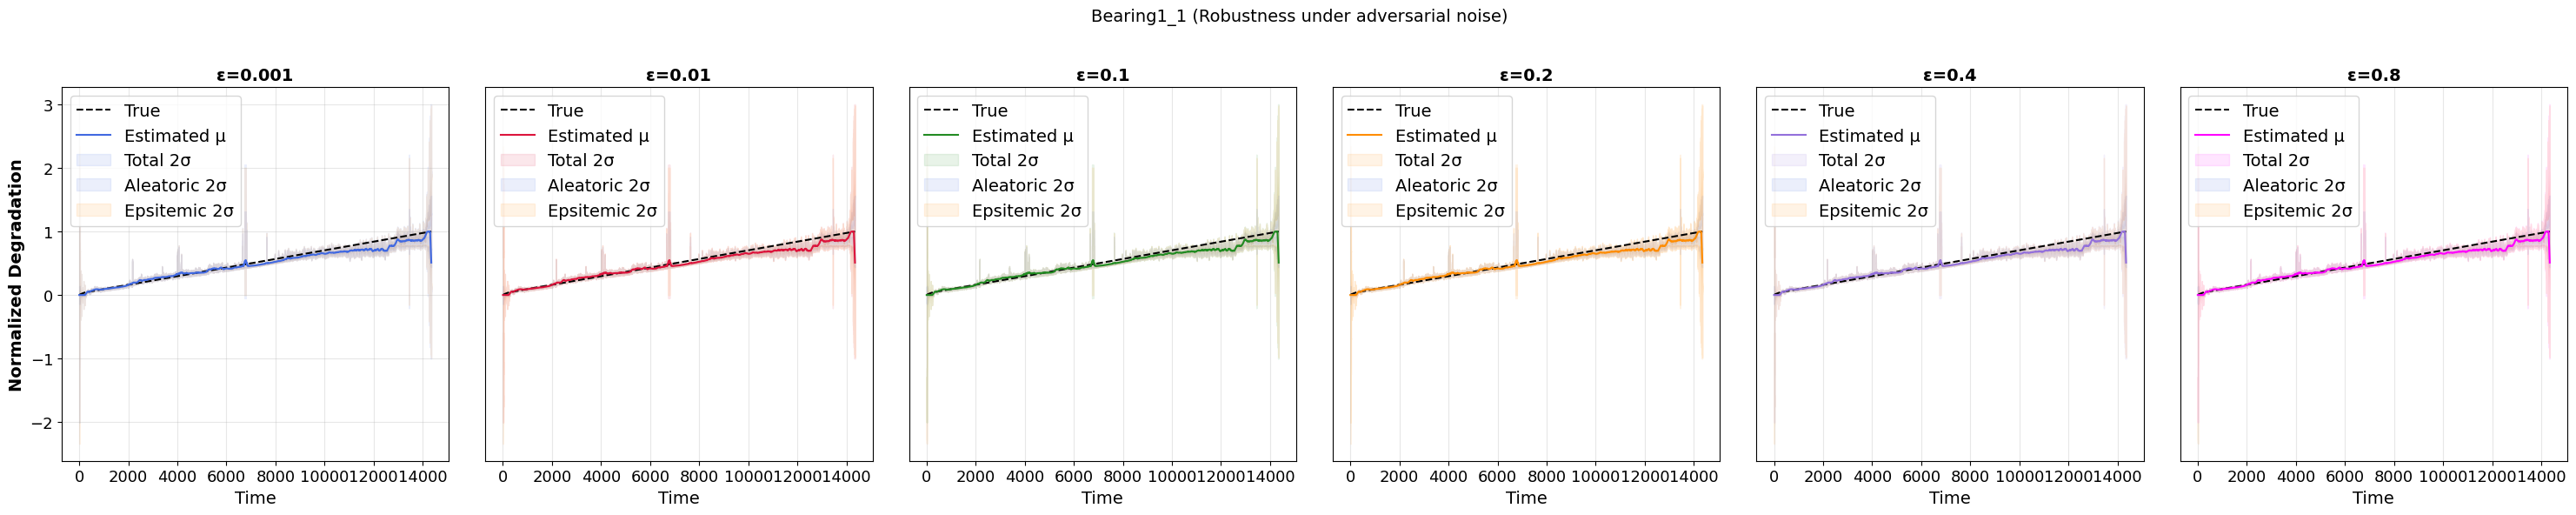

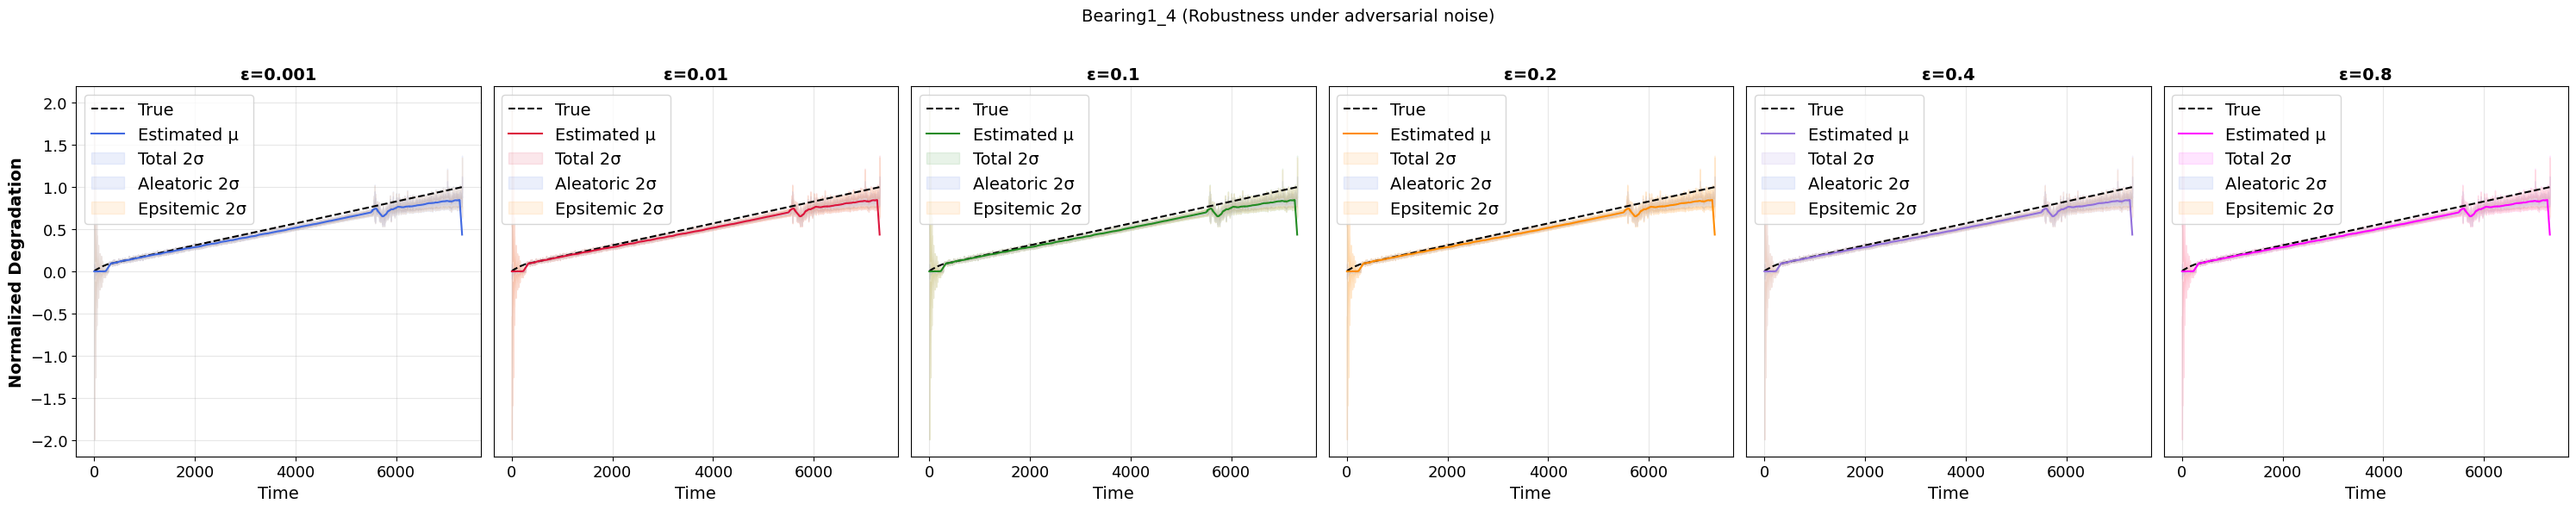

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from models.UQ_SNER import UQ_SNER
from networks.UQ_networks import ecfc_network
from utils.preprocess import process_features, moving_average
from networks.losses import NLL
from evidential_deep_learning.losses import EvidentialRegression as edl_loss
# --- CONFIGURATION ---
p = 3.0
P = 4000.0
Ea = 0.1
kB = 8.617e-5
alpha = 1e-5
beta = 5e-6

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

colors = ['royalblue', 'crimson', 'forestgreen', 'darkorange', 'mediumpurple', 'magenta', 'teal']


# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner', 'data_dist': 'IND'},
    ],
}


import tensorflow as tf

def fgsm(model, input_image, input_label, epsilon):
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_label = tf.cast(input_label, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        pred = model.model(input_image,training=False)
        loss = edl_loss(input_label,pred)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adversarial_example = input_image + epsilon * signed_grad
    adversarial_example = tf.clip_by_value(adversarial_example, -5, 5)
    return adversarial_example




def plot_contour(mu_values, var_values, ax):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap='Blues')
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$', fontsize=14)
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylim(0, 0.01)
    ax.set_ylabel(r'$\sigma^2$', fontsize=14)
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sngp = UQ_SNER(ecfc_network,lambbda=0.5)
sngp.load_weights(os.path.join(weights_dir, 'PI_ECFC_05.hdf5.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---
plt.style.use('seaborn-v0_8-deep')
epsilon_values = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8]

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mus = []
            vars_ = []
            stds = []
            mas = []

            for eps in epsilon_values:
                # Generate adversarial samples with fgsm
                X_adv = fgsm(sngp, X_scaled, y_true, epsilon=eps)

                # Predict on adversarial inputs
                mu_adv, aleatoric_adv, epistemic_adv, var_adv = sngp._predict(X_scaled)

                
                mu_adv = np.clip(mu_adv, 0, 1)
                var_adv = np.clip(var_adv, 0, 1)
                std_adv = np.sqrt(var_adv)
                ma_adv = moving_average(mu_adv)

                mus.append(mu_adv)
                vars_.append(var_adv)
                stds.append(std_adv)
                mas.append(ma_adv)

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(f"{bearing_name} (Robustness under adversarial noise)", fontsize=14)
            x_vals = np.arange(len(y_true))

            titles = [f"ε={eps}" for eps in epsilon_values]

            for i, eps in enumerate(epsilon_values):
                idx = i
                ax[idx].plot(y_true, label='True', linestyle='--', color='black')
                ax[idx].plot(mas[i], label='Estimated μ', color=colors[i])
                ax[idx].fill_between(x_vals, mus[i] - 2*stds[i], mus[i] + 2*stds[i], color=colors[i], alpha=0.1, label=r'Total 2σ')
                ax[idx].fill_between(x_vals, mus[i]-2*np.sqrt(aleatoric_adv), mus[i]+2*np.sqrt(aleatoric_adv), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
                ax[idx].fill_between(x_vals, mus[i]-2*np.sqrt(epistemic_adv), mus[i]+2*np.sqrt(epistemic_adv), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
        
                ax[idx].set_title(titles[i],fontsize=14,fontweight='bold')
                ax[idx].set_xlabel('Time', fontsize=14)
                if i == 0:
                    ax[idx].set_ylabel(f"Normalized Degradation", fontsize=14, fontweight='bold')
                else:
                    ax[idx].set_ylabel('')
                    ax[idx].set_yticks([])
                ax[idx].legend(loc='upper left', fontsize=14)
                ax[idx].grid(True, alpha=0.3)


            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'PGCFC_FGSM_{bearing_name}.png'), dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")


In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import multivariate_normal
from models.UQ_SNER import UQ_SNER
from networks.UQ_networks import ecfc_network,eltc_network
from utils.preprocess import process_features, moving_average
from networks.losses import NLL
from evidential_deep_learning.losses import EvidentialRegression as edl_loss
# --- CONFIGURATION ---
p = 3.0
P = 4000.0
Ea = 0.1
kB = 8.617e-5
alpha = 1e-5
beta = 5e-6

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13


# --- DIRECTORIES ---
dir = os.getcwd()
feature_dir = os.path.join(dir, 'tf_features')
weights_dir = os.path.join(dir, 'model_weights')
stats_dir = os.path.join(dir, 'statistics')
save_dir = os.path.join(dir, 'bearing_plots')
os.makedirs(save_dir, exist_ok=True)

colors = ['royalblue', 'crimson', 'forestgreen', 'darkorange', 'mediumpurple', 'magenta', 'teal']


# --- BEARING GROUPS ---
bearings = {
    '100Hz4kN': [
        {'name': 'Bearing1_1', 'failure': 'Outer', 'data_dist': 'OOD'},
        {'name': 'Bearing1_4', 'failure': 'Inner', 'data_dist': 'IND'},
    ],
}


import tensorflow as tf

def fgsm(model, input_image, input_label, epsilon):
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_label = tf.cast(input_label, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        pred = model.model(input_image,training=False)
        loss = edl_loss(input_label,pred)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adversarial_example = input_image + epsilon * signed_grad
    adversarial_example = tf.clip_by_value(adversarial_example, -5, 5)
    return adversarial_example




def plot_contour(mu_values, var_values, ax):
    mu_mean = np.mean(mu_values)
    sigma2_mean = np.mean(var_values)
    cov = np.cov(np.vstack([mu_values, var_values]))
    cov += np.eye(2) * 1e-6

    mu = np.linspace(mu_mean - 1, mu_mean + 1, 200)
    sigma2 = np.linspace(max(1e-6, sigma2_mean - 1), sigma2_mean + 1, 200)
    MU, SIGMA2 = np.meshgrid(mu, sigma2)
    pos = np.dstack((MU, SIGMA2))

    rv = multivariate_normal([mu_mean, sigma2_mean], cov)
    Z = rv.pdf(pos)

    ax.contourf(MU, SIGMA2, Z, levels=10, cmap='Blues')
    ax.contour(MU, SIGMA2, Z, colors='black', linewidths=0.5)
    ax.set_xlabel(r'$\mu$', fontsize=14)
    ax.set_xlim(mu_mean - 1, mu_mean + 1)
    ax.set_ylim(0, 0.01)
    ax.set_ylabel(r'$\sigma^2$', fontsize=14)
    ax.grid(True, alpha=0.3)

# --- LOAD MODELS ---
sngp = UQ_SNER(eltc_network,lambbda=0.5)
sngp.load_weights(os.path.join(weights_dir, 'PI_ELTC_05.hdf5.keras'))

# --- MAIN LOOP ---
# --- MAIN LOOP ---
plt.style.use('seaborn-v0_8-deep')
epsilon_values = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8]

for condition, bearing_list in bearings.items():
    for bearing in bearing_list:
        try:
            bearing_name = bearing['name']
            failure_type = bearing['failure']
            data_dist = bearing['data_dist']

            df = pd.read_csv(os.path.join(feature_dir, f'{bearing_name}_features.csv'))

            xh = process_features(np.array(df['Horizontal'].apply(eval).tolist()))
            xv = process_features(np.array(df['Vertical'].apply(eval).tolist()))
            vibration_features = np.concatenate((xh, xv), axis=-1)
            t_data = np.array(df['Time'].values).reshape(-1, 1)
            T_data = np.array(df['Temperature'].values + 273.15).reshape(-1, 1)
            X = np.concatenate([vibration_features, t_data, T_data], axis=1)

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            y_true = np.array(df['Degradation'].values)

            mus = []
            vars_ = []
            stds = []
            mas = []

            for eps in epsilon_values:
                # Generate adversarial samples with fgsm
                X_adv = fgsm(sngp, X_scaled, y_true, epsilon=eps)

                # Predict on adversarial inputs
                mu_adv, aleatoric_adv, epistemic_adv, var_adv = sngp._predict(X_scaled)

                
                mu_adv = np.clip(mu_adv, 0, 1)
                var_adv = np.clip(var_adv, 0, 1)
                std_adv = np.sqrt(var_adv)
                ma_adv = moving_average(mu_adv)

                mus.append(mu_adv)
                vars_.append(var_adv)
                stds.append(std_adv)
                mas.append(ma_adv)

            # --- PLOTTING ---
            fig, ax = plt.subplots(1, 6, figsize=(30, 6))
            fig.suptitle(f"{bearing_name} (Robustness under adversarial noise)", fontsize=14)
            x_vals = np.arange(len(y_true))

            titles = [f"ε={eps}" for eps in epsilon_values]

            for i, eps in enumerate(epsilon_values):
                idx = i
                ax[idx].plot(y_true, label='True', linestyle='--', color='black')
                ax[idx].plot(mas[i], label='Estimated μ', color=colors[i])
                ax[idx].fill_between(x_vals, mus[i] - 2*stds[i], mus[i] + 2*stds[i], color=colors[i], alpha=0.1, label=r'Total 2σ')
                ax[idx].fill_between(x_vals, mus[i]-2*np.sqrt(aleatoric_adv), mus[i]+2*np.sqrt(aleatoric_adv), color='royalblue', alpha=0.1, label=r'Aleatoric 2σ')
                ax[idx].fill_between(x_vals, mus[i]-2*np.sqrt(epistemic_adv), mus[i]+2*np.sqrt(epistemic_adv), color='darkorange', alpha=0.1, label=r'Epsitemic 2σ')
        
                ax[idx].set_title(titles[i],fontsize=14,fontweight='bold')
                ax[idx].set_xlabel('Time', fontsize=14)
                if i == 0:
                    ax[idx].set_ylabel(f"Normalized Degradation", fontsize=14, fontweight='bold')
                else:
                    ax[idx].set_ylabel('')
                    ax[idx].set_yticks([])
                ax[idx].legend(loc='upper left', fontsize=14)
                ax[idx].grid(True, alpha=0.3)


            fig.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
            fig.savefig(os.path.join(save_dir, f'PGLTC_FGSM_{bearing_name}.png'), dpi=600)
            plt.close(fig)

        except Exception as e:
            print(f"Error processing {bearing_name}: {e}")

Raspberyy pi Implementation

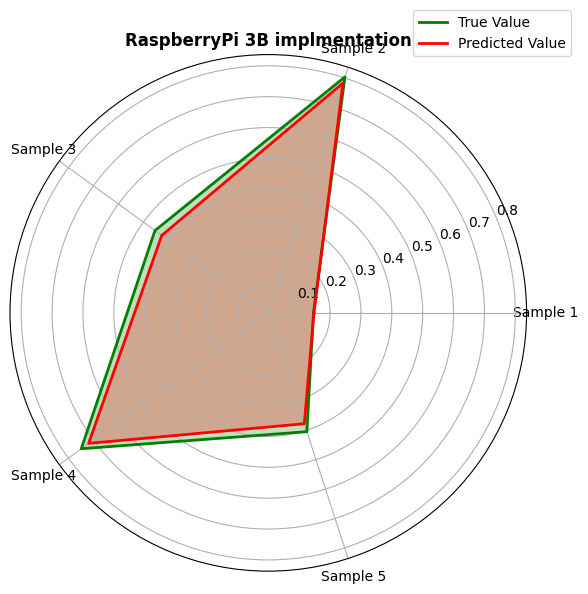

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Sample labels
labels = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5']

# True and predicted values
true_values = [0.1464, 0.8035, 0.4535, 0.7485, 0.4046]
predicted_values = [0.1479, 0.7823, 0.4264, 0.7190, 0.3774]

# Number of variables we're plotting
num_vars = len(labels)

# Compute angle for each axis in the plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Close the radar chart loop by appending the first value again
true_values += true_values[:1]
predicted_values += predicted_values[:1]

# Set up the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot true values
ax.plot(angles, true_values, color='green', linewidth=2, label='True Value')
ax.fill(angles, true_values, color='green', alpha=0.25)

# Plot predicted values
ax.plot(angles, predicted_values, color='red', linewidth=2, label='Predicted Value')
ax.fill(angles, predicted_values, color='red', alpha=0.25)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Add title and legend
ax.set_title("RaspberryPi 3B implmentation", fontsize=12, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Display plot
plt.tight_layout()
plt.show()
